<a href="https://colab.research.google.com/github/seven320/air_pollutants/blob/main/FP068_063.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Env

In [1]:
!nvidia-smi

Wed May 25 12:49:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os, sys
COLAB = "google.colab" in sys.modules

if COLAB:
    from google.colab import drive
    from google.colab import output
    drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
if COLAB:
    !pip install transformers > /dev/null
    !pip install einops > /dev/null
    !pip install optuna > /dev/null
    !pip install pyephem > /dev/null
    # !pip install timm > /dev/null
    # !pip install kaggle > /dev/null
    # !pip install kaggle_datasets > /dev/null
    # !pip install git+https://github.com/albumentations-team/albumentations
    # !pip install tensorflow-determinism
    !pip install -q iterative-stratification
    !pip install python-Levenshtein > /dev/null
    !pip install geopy > /dev/null

    # for gpu
    !git clone --recursive https://github.com/Microsoft/LightGBM
    %cd /content/LightGBM/
    !mkdir build
    !cmake -DUSE_GPU=1 
    !make -j$(nproc)
    !sudo apt-get -y install python-pip

    !sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
    #pandasのエラーが出る場合は上記のコードからpandasを削除

    !sudo -H pip install setuptools numpy scipy scikit-learn -U
    %cd /content/LightGBM/python-package
    !sudo python setup.py install --precompile

    output.clear()

In [4]:
import gc
import json
import math
import os
import random
import re
import time
import copy
import warnings
from requests import get
from contextlib import contextmanager
from typing import List, Optional, TypeVar, Type, Dict
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold, train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import RobustScaler, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
# from einops.layers.torch import Rearrange, Reduce
# import timm
import Levenshtein
import ephem
from geopy.distance import geodesic
import pickle

from tqdm.notebook import tqdm
from transformers import AdamW, get_cosine_schedule_with_warmup
from typing import Optional, Tuple
from xgboost import XGBRegressor
import lightgbm as lgb
import optuna

In [5]:
warnings.simplefilter('ignore')

In [6]:
if COLAB:    
    NOTEBOOK_NAME = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
    print(NOTEBOOK_NAME)

FP068-063


In [7]:
COMPE_NAME = "air_pollutants"
BASE_DIR = f"/content/drive/MyDrive/signate/{COMPE_NAME}"

# KAGGLE ONLY HAS 1, BUT OFFLINE, YOU CAN USE MORE
os.environ["CUDA_VISIBLE_DEVICES"]="0" #0,1,2,3 for four gpu

In [8]:
if COLAB:
    INPUT_DIR = Path(os.path.join(BASE_DIR ,f"input"))
    INPUT_DIR.mkdir(exist_ok=True, parents=True)

    SAVE_DIR = Path(os.path.join(BASE_DIR ,f"models/{NOTEBOOK_NAME}"))
    SAVE_DIR.mkdir(exist_ok=True, parents=True)

    OOF_DIR = Path(os.path.join(BASE_DIR, f"oof/{NOTEBOOK_NAME}"))
    OOF_DIR.mkdir(exist_ok=True, parents = True)

    SUB_DIR = Path(os.path.join(BASE_DIR, f"submission/{NOTEBOOK_NAME}"))
    SUB_DIR.mkdir(exist_ok=True, parents = True)

In [9]:
train_df = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(INPUT_DIR, "test.csv"))
sample_df = pd.read_csv(os.path.join(INPUT_DIR, "submit_sample.csv"), names=["id", "predict"])

print(train_df.shape, test_df.shape, sample_df.shape)

(195941, 54) (53509, 53) (53509, 2)


In [10]:
train_df

,id,year,month,day,Country,City,lat,lon,co_cnt,co_min,...,ws_min,ws_mid,ws_max,ws_var,dew_cnt,dew_min,dew_mid,dew_max,dew_var,pm25_mid
0,1,2019,1,1,Australia,Brisbane,-27.46794,153.02809,38,0.749,...,0.241,1.088,3.101,1.983,17,7.671,10.358,15.112,13.424,19.901
1,2,2019,1,1,Australia,Darwin,-12.46113,130.84185,47,2.594,...,0.828,3.473,7.396,10.411,62,21.324,23.813,24.221,2.021,13.741
2,3,2019,1,1,Australia,Melbourne,-37.81400,144.96332,17,1.190,...,0.000,2.107,8.089,15.719,22,10.309,13.133,15.422,6.355,25.918
3,4,2019,1,1,Australia,Newcastle,-32.92953,151.78010,63,4.586,...,0.284,0.503,3.592,2.485,116,7.146,10.685,13.344,9.417,174.370
4,5,2019,1,1,Australia,Perth,-31.95224,115.86140,47,4.689,...,0.500,0.755,3.396,1.937,93,1.091,3.277,12.272,4.109,167.063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195936,195937,2021,12,31,United States,Jacksonville,30.33218,-81.65565,12,0.694,...,2.195,2.710,6.125,3.757,12,16.774,22.679,26.058,13.252,16.150
195937,195938,2021,12,31,United States,Las Vegas,36.17497,-115.13722,14,0.528,...,1.002,2.974,6.861,8.354,12,10.432,14.741,15.827,7.078,16.895
195938,195939,2021,12,31,United States,Milwaukee,43.03890,-87.90647,171,1.975,...,0.994,1.087,2.578,0.612,26,2.049,3.531,6.686,5.286,86.299
195939,195940,2021,12,31,Vietnam,Hanoi,21.02450,105.84117,31,2.613,...,1.005,3.058,6.005,6.085,51,1.922,7.443,7.716,4.642,36.523


## pseude label

In [11]:
oof_df = pd.read_csv(os.path.join(BASE_DIR, "oof", "FP046-043", "oof.csv"))
submit_df = pd.read_csv(os.path.join(BASE_DIR, "submission", "FP046-043", "submission.csv"), names = ["id", "pm25_mid"])

In [12]:
oof_df_ = oof_df.rename(columns = {"oof":"pseude_pm25_mid"})
submit_df_ = submit_df.rename(columns = {"pm25_mid":"pseude_pm25_mid"})

## add city population

In [13]:
# population_df = pd.read_csv(os.path.join(INPUT_DIR, "city_population.csv"))
# population_df["City"] = population_df["Name"]

In [14]:
# # 同じ都市名かつ国名のものを削除する
# population_df["CC"] = population_df["Country"] + population_df["City"]
# population_df["CC"].value_counts()
# for k, v in population_df["CC"].value_counts().items():
#     # print(k, v)
#     if v > 1:
#         print(f"{k} の行を削除")
#         population_df = population_df[population_df["CC"] != k]

In [15]:
# def df_to_country_dict(df: pd.DataFrame) -> Dict:
#     country_city = {}

#     for t_c in set(df["Country"].tolist()):
#         country_city[t_c] = []

#     for country, city in zip(df["Country"], df["City"]):
#         country_city[country].append(city)

#     for k, v in country_city.items():
#         country_city[k] = set(v)

#     return country_city

In [16]:
# train_country_city = df_to_country_dict(pd.concat([train_df, test_df]))

# p_country_city = df_to_country_dict(population_df)

In [17]:
# def cal_leven(str1: str, str2: str) -> float:
#     # レーベンシュタイン距離の取得
#     lev_dist = Levenshtein.distance(str1, str2)
#     # 標準化(長い方の文字列の長さで割る)
#     divider = len(str1) if len(str1) > len(str2) else len(str2)
#     lev_dist = lev_dist / divider
#     # 指標を合わせる(0:完全不一致 → 1:完全一致)
#     return 1 - lev_dist

In [18]:
# city_pairs = {}

# for t_k, t_values in train_country_city.items():
#     for p_k, p_values in p_country_city.items():
#         # countryが一致
#         if t_k != p_k:
#             continue
#         for t_v in t_values:
#             max_score = -1
#             for p_v in p_values:
#                 score = cal_leven(t_v, p_v)
#                 if max_score < score:
#                     pairs = [t_v, p_v]
#                     max_score = score

#             if max_score > 0.8:
#                 city_pairs[pairs[1]] = pairs[0]
# print(f"pair cities:{len(city_pairs)}")

In [19]:
# a = population_df["City"]
# for key, value in city_pairs.items():
#     # print(key, value)
#     a = copy.deepcopy(a.replace(key, value))

# population_df["City"] = a

In [20]:
# if not "Prev" in train_df.columns:
#     train_df = train_df.merge(population_df[["rank", "City", "Country", "Population", "Prev", "Growth"]], on = ["City", "Country"], how="left")
#     test_df = test_df.merge(population_df[["rank", "City", "Country",  "Population", "Prev", "Growth"]], on = ["City", "Country"], how="left")

# assert len(test_df) == len(sample_df)

## add target encode

In [21]:
if not "target_count" in train_df.columns:
    target_df = train_df[["Country", "pm25_mid"]].groupby("Country", as_index = 1).describe()

    target_df = target_df.rename(columns = {
        "count": "target_count",
        "mean": "target_mean",
        "std": "target_std",
        "25%": "target_25%",
        "50%": "target_50%",
        "75%": "target_75%",
        "max": "target_max"
    }).reset_index()
    train_df = train_df.merge(pd.concat([target_df["Country"], target_df["pm25_mid"]], axis = 1), on = "Country", how = "left")
    test_df = test_df.merge(pd.concat([target_df["Country"], target_df["pm25_mid"]], axis = 1), on = "Country", how = "left")

### add days

## 都市を近い順に入力(上位15)

In [22]:
use_city = 5

In [23]:
# 全ての都市を抽出
all_df = pd.concat([train_df, test_df])
lat_lons = all_df[["City", "lat", "lon"]].drop_duplicates()

train_cities = train_df["City"].unique()
test_cities = test_df["City"].unique()
all_cities = all_df["City"].unique()

In [24]:
 # 各都市ごとの距離を格納
 #
#  nearest_cities = {
#       City1 = {
            # City2: 500km
            # City3: 1000km
# }
# } 

nearest_cities = {}
for i in tqdm(range(len(lat_lons))):
    City1, lat1, lon1 = lat_lons.iloc[i]
    pos1 = np.array([lat1, lon1])
    
    nearest_city = {}
    for j in range(len(lat_lons)):
        if i == j:
            continue
        
        City2, lat2, lon2 = lat_lons.iloc[j]
        pos2 = np.array([lat2, lon2])
        
        dis = geodesic(pos1, pos2)
        
        nearest_city[City2] = dis

    nearest_cities[City1] = nearest_city

  0%|          | 0/302 [00:00<?, ?it/s]

In [25]:
nearest_sort_cities = []

for city1 in nearest_cities.keys():
    nearest_sort_city = dict(sorted(nearest_cities[city1].items(), key = lambda item: item[1])).keys()
    nearest_sort_cities.append([city1] + list(nearest_sort_city)[:use_city])

In [26]:
target_en_bycities_detail = train_df[["City","year", "month","day", "pm25_mid", "so2_mid", "no2_mid", "co_mid", ]].groupby(["City", "year", "month", "day"], as_index = 0).agg("mean").reset_index(drop=True)

In [27]:
# cities = pd.DataFrame(target_en_bycities_detail["City"].unique(), columns = ["City"])
cities = pd.DataFrame(all_df["City"].unique(), columns=["City"])
year_month_day = target_en_bycities_detail.groupby(["year", "month", "day"], as_index=0).agg("mean")[["year", "month", "day"]]

city_year_month_day = pd.merge(cities, year_month_day, how = "cross")

In [28]:
target_en_bycities = train_df[["City","year", "month", "pm25_mid", "so2_mid", "no2_mid", "co_mid"]].groupby(["City", "month"], as_index = 0).agg("mean").reset_index(drop=True)

In [29]:
target_en = pd.merge(city_year_month_day, target_en_bycities_detail, on = ["City", "year", "month", "day"], how = "left")
target_en_fillna = pd.merge(target_en, target_en_bycities, on = ["City", "year", "month"], how = "left")
target_en_fillna["pm25_mid"] = target_en_fillna["pm25_mid_x"].combine_first(target_en_fillna["pm25_mid_y"])
target_en_fillna = target_en_fillna.drop(columns = ["pm25_mid_x", "pm25_mid_y"])
target_en_fillna["so2_mid"] = target_en_fillna["so2_mid_x"].combine_first(target_en_fillna["so2_mid_y"])
target_en_fillna["no2_mid"] = target_en_fillna["no2_mid_x"].combine_first(target_en_fillna["no2_mid_y"])
target_en_fillna["co_mid"] = target_en_fillna["co_mid_x"].combine_first(target_en_fillna["co_mid_y"])
target_en_fillna = target_en_fillna.drop(columns = ["so2_mid_x", "so2_mid_y"])
target_en_fillna = target_en_fillna.drop(columns = ["no2_mid_x", "no2_mid_y"])
target_en_fillna = target_en_fillna.drop(columns = ["co_mid_x", "co_mid_y"])

In [30]:
# Config
NUM_FOLDS = 5

In [31]:
#############
## Utility ##
#############
@contextmanager
def timer(name: str):
    t0 = time.time()
    print(f"[{name}] start")
    yield
    print(f"[{name}] done - elapsed {time.time() - t0:.2f}s")

In [32]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [33]:
train_df.head()

,id,year,month,day,Country,City,lat,lon,co_cnt,co_min,...,dew_var,pm25_mid,target_count,target_mean,target_std,min,target_25%,target_50%,target_75%,target_max
0,1,2019,1,1,Australia,Brisbane,-27.46794,153.02809,38,0.749,...,13.424,19.901,5656.0,37.362265,25.919644,0.0,19.526,28.6445,52.50325,189.517
1,2,2019,1,1,Australia,Darwin,-12.46113,130.84185,47,2.594,...,2.021,13.741,5656.0,37.362265,25.919644,0.0,19.526,28.6445,52.50325,189.517
2,3,2019,1,1,Australia,Melbourne,-37.81400,144.96332,17,1.190,...,6.355,25.918,5656.0,37.362265,25.919644,0.0,19.526,28.6445,52.50325,189.517
3,4,2019,1,1,Australia,Newcastle,-32.92953,151.78010,63,4.586,...,9.417,174.370,5656.0,37.362265,25.919644,0.0,19.526,28.6445,52.50325,189.517
4,5,2019,1,1,Australia,Perth,-31.95224,115.86140,47,4.689,...,4.109,167.063,5656.0,37.362265,25.919644,0.0,19.526,28.6445,52.50325,189.517


In [34]:
train_city = train_df["City"].unique().tolist()
test_city = test_df["City"].unique().tolist()

train_city_cnt = len(train_city)
test_city_cnt = len(test_city)

print(f"train city count: {train_city_cnt}")
print(f"test city count: {test_city_cnt}")

print(f"{len(set(train_city) & set(test_city))}")

train city count: 239
test city count: 63
0


In [35]:
kf = GroupKFold(n_splits = NUM_FOLDS)

if not "kfold" in train_df.columns:
    folds = copy.deepcopy(train_df[["id"]])
    folds["kfold"] = -1

    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df, train_df["pm25_mid"], train_df["City"])):
        print(f"train_idx: {len(train_idx)}, valid_idx: {len(valid_idx)}")
        folds.loc[valid_idx, "kfold"] = fold

    train_df = train_df.merge(folds[["id", "kfold"]], on="id", how="left")

train_idx: 156755, valid_idx: 39186
train_idx: 156758, valid_idx: 39183
train_idx: 156760, valid_idx: 39181
train_idx: 156730, valid_idx: 39211
train_idx: 156761, valid_idx: 39180


# Train

In [36]:
import logging
from typing import List, Optional, TypeVar

import pandas as pd

class AbstractFeatureTransformer:
    def __init__(self):
        self.name = self.__class__.__name__

    def fit_transform(self, input_df: pd.DataFrame, y=None):
        self.fit(input_df, y)
        return self.transform(input_df)

    def fit(self, input_df: pd.DataFrame, y=None):
        pass

    def transform(self, input_df: pd.DataFrame) -> pd.DataFrame:
        raise NotImplementedError

Transformer = TypeVar("Transformer", bound=AbstractFeatureTransformer)

def extract_features(input_df: pd.DataFrame,
                     transformers: List[Transformer],
                     fit: bool = True,
                     logger: Optional[logging.Logger] = None):
    feature_dfs = []
    for transformer in transformers:
        # timerはブロックの実行時間を計測するユーティリティ
        with timer(f"Extract features with {transformer.name}", logger):
            if fit:
                feature_dfs.append(transformer.fit_transform(input_df))
            else:
                feature_dfs.append(transformer.transform(input_df))
    all_features = pd.concat(feature_dfs, axis=1)
    return all_features

In [37]:
class Numericals(AbstractFeatureTransformer):
    def transform(self, input_df: pd.DataFrame) -> pd.DataFrame:
        cols = [pd.api.types.is_numeric_dtype(dtype) for dtype in input_df.dtypes]
        return input_df.loc[:, cols]

class LabelEncoding(AbstractFeatureTransformer):
    def __init__(self, columns: List[str]):
        super().__init__()
        self.le_columns = columns
        self.encoders = {
            column: LabelEncoder()
            for column in self.le_columns
        }
        self.__is_fitted = False

    def fit(self, input_df: pd.DataFrame, y: Optional[np.ndarray] = None):
        """
        ラベルに変換する前に欠損値を埋める
        """
        for column in self.le_columns:
            self.encoders[column].fit(input_df[column].fillna(""))
        self.__is_fitted = True

    def transform(
        self, 
        input_df: pd.DataFrame, 
        y: Optional[np.ndarray] = None
    ) -> pd.DataFrame:
        assert self.__is_fitted, "You need to call `fit` first."
        encoded = {}
        for column in self.le_columns:
            encoded[column] = self.encoders[column].transform(
                input_df[column].fillna(""))
        return pd.DataFrame(encoded)

In [38]:
def preprocess_all(train_df:pd.DataFrame, test_df:pd.DataFrame)->pd.DataFrame:
    all_df = pd.concat([train_df, test_df])

    mids = ["co_mid", "o3_mid", "so2_mid", "no2_mid", "temperature_mid", "humidity_mid", "pressure_mid", "ws_mid", "dew_mid", 
            "co_max", "o3_max", "so2_max", "no2_max", "temperature_max", "humidity_max", "pressure_max", "ws_max", "dew_max"]
    cnt = 1
    for i in range(len(mids)):
        if f"scaled_{mids[i]}" in train_df.columns:
            break
        scaler = MinMaxScaler()
        scaler.fit(all_df[[mids[i]]])
        train_df[f"scaled_{mids[i]}"] = scaler.transform(train_df[[mids[i]]])
        test_df[f"scaled_{mids[i]}"] = scaler.transform(test_df[[mids[i]]])
        cnt += 1
    print("min max scaler")

    return train_df, test_df

In [39]:
def preprocess(df:pd.DataFrame)->pd.DataFrame:
    df_ = copy.deepcopy(df)
    # 年月/年月日を追加

    df_["year_month"] = df_["year"].astype("str") + df_["month"].astype("str")
    df_["year_month_day"] = df_["year"].astype("str") + df_["month"].astype("str") + df_["day"].astype("str")
    df_["month_day"] = df_["month"].astype("str") + df_["day"].astype("str")

    # 月日国/月日都市を追加
    df_["month_day_country"] = df_["month"].astype("str") + df_["day"].astype("str") + df_["Country"].astype("str") 
    df_["month_day_city"] =  df_["month"].astype("str") + df_["day"].astype("str") + df_["City"].astype("str") 

    # 経度をcosに変換
    cnt = 0

    if not "lon_cos" in df_.columns:
        df_["lon_cos"] = np.cos(np.radians((df_["lon"] + 180)))
        df_["lon_sin"] = np.sin(np.radians((df_["lon"] + 180)))
        df_["month_cos"] = np.cos(np.radians(df_["month"] / 12 * 360))
        df_["month_sin"] = np.sin(np.radians(df_["month"] / 12 * 360))
        print("add lon_cos, lon_sin, month_cos, month_sin")
        cnt += 4

    # 四則演算

    # 南半球を北半球のmonthに変更
    if not "month_world" in df_.columns:
        df_["month_world"] = df_["month"]
        df_.loc[df_["lat"] < 0, "month_world"] = df_["month"] + 6
        df_.loc[df_["month_world"] > 12, "month_world"] = df_["month"] - 6
        print("add month_world")
        cnt += 1
    # mid同士を4則
    columns = df_.columns
    mids = []
    for c in columns:
        if "_mid" in c and c != "pm25_mid":
            mids.append(c)

    # 曜日を追加
    def _cal_sun_time(lat:float, lon:float, year:float, month:float, day: float)->float:
        location = ephem.Observer()
        location.lat = str(lat)
        location.lon = str(lon)
        sun = ephem.Sun()

        location.date = datetime.date(year = int(year), month = int(month), day = int(day))
        sun_time_tmp1 = ephem.localtime(location.next_rising(sun)) - ephem.localtime(location.next_setting(sun))
        sun_time_tmp2 = ephem.localtime(location.next_setting(sun)) - ephem.localtime(location.next_rising(sun))

        sun_time = max(sun_time_tmp1.seconds, sun_time_tmp2.seconds)

        return sun_time
    if not "sun_time" in df_.columns:
        u_cols = ["lat", "lon", "year", "month", "day"]

        df_["sun_time"] = -1
        df_["week"] = -1

        mini_df = df_[u_cols]

        sun_time = np.zeros(len(df_))
        weeks = np.zeros(len(df_))
        for i in tqdm(range(len(mini_df))):
            lat, lon, year, month, day = mini_df.iloc[i]
            sun_time[i] = _cal_sun_time(lat, lon, year, month, day)

            # 曜日
            date = datetime.date(int(year), int(month), int(day))
            weeks[i] = date.weekday()

        df_["sun_time"] = sun_time
        df_["week"] = weeks

        print("add sun_time, weeks")
    cnt += 2

    mids = ["co_mid", "o3_mid", "so2_mid", "no2_mid", "temperature_mid", "humidity_mid", "pressure_mid", "ws_mid", "dew_mid"]
    for i in range(len(mids)):
        for j in range(i):
            mid0, mid1 = mids[i], mids[j]
            df_[f"{mid0}+{mid1}"] = df_[mid0] + df_[mid1]

            cnt += 1
    print("add mids + cal")
    scaled_mids = ["scaled_co_mid", "scaled_o3_mid", "scaled_so2_mid", "scaled_no2_mid"]
    for i in range(len(scaled_mids)):
        for j in range(i):
            mid0, mid1 = scaled_mids[i], scaled_mids[j]
            df_[f"{mid0}+{mid1}"] = df_[mid0] + df_[mid1]
            cnt += 1
            for k in range(j):
                mid2 = scaled_mids[k]
                df_[f"{mid0}+{mid1}+{mid2}"] = df_[mid0] + df_[mid1] + df_[mid2]
                cnt += 1
                for l in range(k):
                    mid3 = scaled_mids[l]
                    df_[f"{mid0}+{mid1}+{mid2}+{mid3}"] = df_[mid0] + df_[mid1] + df_[mid2] + df_[mid3]
                    cnt += 1
    print("add scaled mids")

    maxs = ["co_max", "o3_max", "so2_max", "no2_max", "temperature_max", "humidity_max", "pressure_max", "ws_max", "dew_max"]
    for i in range(len(maxs)):
        for j in range(i):
            max0, max1 = maxs[i], maxs[j]
            df_[f"{max0}+{max1}"] = df_[max0] + df_[max1]

    scaled_maxs = ["scaled_co_max", "scaled_o3_max", "scaled_so2_max", "scaled_no2_max"]
    for i in range(len(scaled_maxs)):
        for j in range(i):
            max0, max1 = scaled_maxs[i], scaled_maxs[j]
            df_[f"{max0}+{max1}"] = df_[max0] + df_[max1]
            cnt += 1
            for k in range(j):
                max2 = scaled_maxs[k]
                df_[f"{max0}+{max1}+{max2}"] = df_[max0] + df_[max1] + df_[max2]
                cnt += 1
                for l in range(k):
                    max3 = scaled_maxs[l]
                    df_[f"{max0}+{max1}+{max2}+{max3}"] = df_[max0] + df_[max1] + df_[max2] + df_[max3]
                    cnt += 1
    print("add scaled maxs")

    print(f"add {cnt} columns")

    return df_

In [40]:
class AbstractTreeModel:
    def __init__(self, prediction_type="regression"):
        self.model = None
        self.prediction_type = prediction_type

    def train(self,
              params: dict,
              X_train: pd.DataFrame,
              y_train: np.ndarray,
              X_val: pd.DataFrame,
              y_val: np.ndarray,
              train_weights: Optional[np.ndarray] = None,
              val_weights: Optional[np.ndarray] = None,
              train_params: Optional[dict] = None):
        if train_params is None:
            train_params = {}

        model = self._train(
            params,
            X_train, y_train,
            X_val, y_val,
            train_weights, val_weights,
            train_params)
        self.model = model
        return self

    def _train(self,
               params,
               X_train,
               y_train,
               X_val,
               y_val,
               train_weights,
               val_weights,
               train_params):
        raise NotImplementedError

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        raise NotImplementedError

    @property
    def feature_names_(self):
        raise NotImplementedError

    @property
    def feature_importances_(self):
        raise NotImplementedError

    def _check_if_trained(self):
        assert self.model is not None, "You need to train the model first"

class LGBModel(AbstractTreeModel):
    def _train(self,
               params,
               X_train, y_train,
               X_val, y_val,
               train_weights, val_weights,
               train_params):
        trn_data = lgb.Dataset(X_train, y_train, weight=train_weights)
        val_data = lgb.Dataset(X_val, y_val, weight=val_weights)
        model = lgb.train(params=params,
                          train_set=trn_data,
                          valid_sets=[trn_data, val_data],
                          **train_params,)
                        #   verbose_eval=False)
        return model

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        self._check_if_trained()
        return self.model.predict(X, num_iteration=self.model.best_iteration)

    @property
    def feature_names_(self):
        self._check_if_trained()
        return self.model.feature_name()

    @property
    def feature_importances_(self):
        self._check_if_trained()
        return self.model.feature_importance(importance_type="gain")

class XGBModel(AbstractTreeModel):
    def _train(self,
               params,
               X_train, y_train,
               X_val, y_val,
               train_weights, val_weights,
               train_params):
        model = XGBRegressor(**params,
            )

        model.fit(X_train, y_train, 
                  eval_set = [(X_val, y_val)], 
                  **train_params
                  )

        return model

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        self._check_if_trained()
        return self.model.predict(X, self.model.best_iteration)

    @property
    def feature_names_(self):
        self._check_if_trained()
        # return self.use_cols

    @property
    def feature_importances_(self):
        self._check_if_trained()
        return self.model.feature_importances_


def get_tree_model(name: str) -> Type[AbstractTreeModel]:
    DEFINED_MODELS = {
        "lgb": LGBModel,
        "xgb": XGBModel,
        # 実装していない
        # "cat": CatBoostModel
    }
    model = DEFINED_MODELS.get(name)
    if model is None:
        raise ValueError(
            """Invalid model name: {}.
            Pre-defined model names are as follows: {}""".format(
                name,
                ",".join(DEFINED_MODELS.keys())
            ))
    return model

In [41]:
def viz_feature_importances(feature_importances: pd.DataFrame)-> None:
    fi_gby = feature_importances.groupby("feature").agg({
        "importance": ["mean", "std"]
    }).sort_values(("importance", "mean"), ascending=0).index
    plt.figure(figsize=(30, 20))
    
    sns.barplot(x="importance", y="feature", data=feature_importances, order=fi_gby)

    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

In [42]:
num_cols = [c for c in train_df.columns if train_df[c].dtype != np.object]
if "id" in num_cols:
    num_cols.remove("id")
if "kfold" in num_cols:
    num_cols.remove("kfold")
num_cols.remove("pm25_mid")

target_cols = "pm25_mid"

In [43]:
train_df0, test_df0 = preprocess_all(train_df, test_df)

train_df1 = preprocess(train_df0)
test_df1 = preprocess(test_df0)

min max scaler
add lon_cos, lon_sin, month_cos, month_sin
add month_world


  0%|          | 0/195941 [00:00<?, ?it/s]

add sun_time, weeks
add mids + cal
add scaled mids
add scaled maxs
add 65 columns
add lon_cos, lon_sin, month_cos, month_sin
add month_world


  0%|          | 0/53509 [00:00<?, ?it/s]

add sun_time, weeks
add mids + cal
add scaled mids
add scaled maxs
add 65 columns


In [44]:
IDW_ps = [1, 1.2, 1.5, 2]
days = [-2, -1, 0, 1, 2]

In [45]:
cat_cols = ["Country", "City", "year_month", "year_month_day", "month_day", "month_day_city", "month_day_country", "nearest_city"] 

day_columns = ["co_mid", "o3_mid", "so2_mid", "no2_mid", "temperature_mid", "humidity_mid", "pressure_mid", "ws_mid", "dew_mid"] + \
["scaled_no2_mid+scaled_so2_mid+scaled_o3_mid+scaled_co_mid", "scaled_co_mid"] + \
["nearest_pm25_mid", ] + \
[f"IDW_p{p}_pm25_mid" for p in IDW_ps] 

IDW_columns = ["pm25_mid", "no2_mid", "so2_mid", "co_mid"]

num_cols = list(set(train_df1.columns) - set(cat_cols + ["pm25_mid", "kfold", "id", "year"])) + \
 ["nearest_pm25_mid"] + \
[f"dis{i}km_pm25_mid" for i in [100, 300, 500, 1000]] +\
[f"IDW_p{p}_pm25_mid" for p in IDW_ps]

for p in IDW_ps:
    for IDW_c in IDW_columns:
        if IDW_c == "pm25_mid": continue
        num_cols += [f"IDW_p{p}_{IDW_c}"] 
        num_cols += [f"ratio_p{p}_{IDW_c}"]  
        num_cols += [f"correction{IDW_c}_IDW_p{p}_pm25_mid"]

for day in days:
    for day_column in day_columns:
        if day == 0:
            continue
        num_cols += [f"{day}d_{day_column}"]

use_cols = num_cols + cat_cols

#### tuning

In [46]:
models = []

train_df_ = copy.deepcopy(train_df1)
test_df_ = copy.deepcopy(test_df1)

oof_df = train_df_[["id"]]
oof_df["oof"] = -1

from lightgbm import early_stopping
from lightgbm import log_evaluation

part_target_en_fillna = target_en_fillna[["City", "year", "month", "day"] + IDW_columns]
target_en_dic_bycity = {}
for IDW_c in IDW_columns:
    target_en_dic_bycity[IDW_c] = {}
    for city in tqdm(part_target_en_fillna["City"].unique()):
        target_en_dic_bycity[IDW_c][city] = part_target_en_fillna.query(f"City == '{city}'")[f"{IDW_c}"].values 


train_datas = []
valid_datas = []
for i in range(NUM_FOLDS):
    # model = get_tree_model("lgb")()
    model = get_tree_model("xgb")()
    train_data = train_df_[train_df_["kfold"] != i].reset_index(drop = True)
    valid_data = train_df_[train_df_["kfold"] == i].reset_index(drop = True)
    print("-" * 5 + f"FOLD {i + 1}/{NUM_FOLDS}" + "-"*5)
    print(f"train_data nums: {len(train_data)}, valid_data nums: {len(valid_data)}")

    # fold内での最近傍を探す
    train_data = train_df_[train_df_["kfold"] != i].reset_index(drop = True)
    print(len(train_data["City"].unique()))

    # 同じfoldの中で最近傍な都市があった場合はその年のtarget_encodingを実施
    # nearest_city_fold_df = copy.deepcopy(nearest_city_df)
    fold_cities = train_data["City"].unique()

    fold_nearest_cities = []
    for (base_c, city1, city2, city3, city4, city5) in nearest_sort_cities:
        if city1 in fold_cities:
            nearest_city = city1
        elif city2 in fold_cities:
            nearest_city = city2
        elif city3 in fold_cities:
            nearest_city = city3
        elif city4 in fold_cities:
            nearest_city = city4
        elif city5 in fold_cities:
            nearest_city = city5
        fold_nearest_cities.append([base_c, nearest_city])
    fold_nearest_cities_df = pd.DataFrame(fold_nearest_cities, columns = ["City", "nearest_city"])

    # add city distance
    fold_nearest_cities_df["distance_km"] = -1
    for j in range(fold_nearest_cities_df.shape[0]):
        city, nearest_city = fold_nearest_cities_df.loc[j, ["City", "nearest_city"]]
        dis = nearest_cities[city][nearest_city]
        fold_nearest_cities_df.loc[j, "distance_km"] = dis.km

    target_en_fillna_ = target_en_fillna.rename(columns = {"City": "nearest_city", "pm25_mid": "nearest_pm25_mid", "co_mid": "co_mid2", "so2_mid": "so2_mid2", "no2_mid": "no2_mid2"})
    fold_nearest_city_target_en = fold_nearest_cities_df.merge(target_en_fillna_, how = "left", on= "nearest_city")
    train_data = train_data.merge(fold_nearest_city_target_en, how = "left", on = ["City", "year", "month", "day"])
    valid_data = valid_data.merge(fold_nearest_city_target_en, how = "left", on = ["City", "year", "month", "day"])
    
# IDWによる計算(https://mf-atelier.sakura.ne.jp/mf-atelier2/a40/)
    part_target_en_fillna = target_en_fillna[["City", "year", "month", "day"] + IDW_columns]
    for p in IDW_ps:
        for IDW_c in IDW_columns:
            part_target_en_fillna[f"IDW_p{p}_{IDW_c}"] = np.nan
            for city in train_cities:
                sum_w = 0
                sum_w_u = 0
                for other_city, dis in nearest_cities[city].items():
                    if not other_city in fold_cities:
                        continue
                # fold_nearest_cities_dfに含まれている都市との距離とpm25の値が欲しい
                    w = 1 / (dis.km ** p)
                    u = target_en_dic_bycity[IDW_c][other_city]
                    u_nan_mask = np.nan_to_num(u)
                    u_nan_flg = np.isnan(u)
                    sum_w_u += w * u_nan_mask
                    sum_w += w * (1 - u_nan_flg)
                part_target_en_fillna.loc[part_target_en_fillna["City"] == city, f"IDW_p{p}_{IDW_c}"] = sum_w_u / sum_w
    part_target_en_fillna = part_target_en_fillna.drop(columns = IDW_columns)
    train_data = train_data.merge(part_target_en_fillna, how = "left", on = ["City", "year", "month", "day"])
    valid_data = valid_data.merge(part_target_en_fillna, how = "left", on = ["City", "year", "month", "day"])
    # 距離に応じた近傍の都市のpm25_mid    
    for dis in [100, 300, 500, 1000]:
        train_data[f"dis{dis}km_pm25_mid"] = np.nan
        valid_data[f"dis{dis}km_pm25_mid"] = np.nan
        train_data.loc[train_data["distance_km"] <= dis, f"dis{dis}km_pm25_mid"] = train_data.loc[train_data["distance_km"] <= dis, "nearest_pm25_mid"]
        valid_data.loc[valid_data["distance_km"] <= dis, f"dis{dis}km_pm25_mid"] = valid_data.loc[valid_data["distance_km"] <= dis, "nearest_pm25_mid"]

    # 日付をずらす
    train_valid_data = pd.concat([train_data, valid_data])
    days_shift_df = city_year_month_day.merge(train_valid_data[day_columns + ["City", "year", "month", "day"]], on = ["City", "year", "month", "day"], how = "left")
    for day in days: 
        for day_column in day_columns:
            if day == 0:
                continue
            days_shift_df[f"{day}d_{day_column}"] = days_shift_df.groupby("City").shift(day)[day_column]

    days_shift_df = days_shift_df.drop(columns = day_columns)

    train_data = train_data.merge(days_shift_df, how = "left",  on = ["City", "year", "month", "day"])
    valid_data = valid_data.merge(days_shift_df, how = "left",  on = ["City", "year", "month", "day"])

    for p in IDW_ps:
        for IDW_c in IDW_columns:
            if IDW_c == "pm25_mid": continue
            train_data[f"ratio_p{p}_{IDW_c}"] = train_data[f"{IDW_c}"] / (train_data[f"IDW_p{p}_{IDW_c}"] + 1e-3)
            train_data[f"correction{IDW_c}_IDW_p{p}_pm25_mid"] = train_data[f"ratio_p{p}_{IDW_c}"] * train_data[f"IDW_p{p}_pm25_mid"]
            valid_data[f"ratio_p{p}_{IDW_c}"] = valid_data[f"{IDW_c}"] / (valid_data[f"IDW_p{p}_{IDW_c}"] + 1e-3)
            valid_data[f"correction{IDW_c}_IDW_p{p}_pm25_mid"] = valid_data[f"ratio_p{p}_{IDW_c}"] * valid_data[f"IDW_p{p}_pm25_mid"]

    train_data = train_data.merge(oof_df_[["id", "pseude_pm25_mid"]], how = "left",  on = ["id"])
    valid_data = valid_data.merge(oof_df_[["id", "pseude_pm25_mid"]], how = "left",  on = ["id"])

    # test
    if i == 0:
        test_nearest_cities = []
        for (base_c, city1, city2, city3, city4, city5) in nearest_sort_cities:
            nearest_city = city1
            test_nearest_cities.append([base_c, nearest_city])
        test_nearest_cities_df = pd.DataFrame(test_nearest_cities, columns = ["City", "nearest_city"])
        
        for j in range(test_nearest_cities_df.shape[0]):
            city, nearest_city = test_nearest_cities_df.loc[j, ["City", "nearest_city"]]
            dis = nearest_cities[city][nearest_city]
            test_nearest_cities_df.loc[j, "distance_km"] = dis.km

        test_nearest_city_target_en = test_nearest_cities_df.merge(target_en_fillna_, how="left", on = "nearest_city")
        test_df_ = test_df_.merge(test_nearest_city_target_en, how="left", on=["City", "year", "month", "day"])

        fortest_target_en_fillna = target_en_fillna[["City", "year", "month", "day"] + IDW_columns]
        for p in IDW_ps:
            for IDW_c in IDW_columns:
                fortest_target_en_fillna[f"IDW_p{p}_{IDW_c}"] = np.nan
                for city in all_cities:
                    sum_w = 0
                    sum_w_u = 0
                    for other_city, dis in nearest_cities[city].items():
                        if not other_city in train_cities:
                            continue
                    # fold_nearest_cities_dfに含まれている都市との距離とpm25の値が欲しい
                        w = 1 / (dis.km ** p)
                        u = target_en_dic_bycity[IDW_c][other_city]
                        u_nan_mask = np.nan_to_num(u)
                        u_nan_flg = np.isnan(u)
                        sum_w_u += w * u_nan_mask
                        sum_w += w * (1 - u_nan_flg)
                    fortest_target_en_fillna.loc[fortest_target_en_fillna["City"] == city, f"IDW_p{p}_{IDW_c}"] = sum_w_u / sum_w
        fortest_target_en_fillna = fortest_target_en_fillna.drop(columns = IDW_columns)
        test_df_ = test_df_.merge(fortest_target_en_fillna, how = "left", on = ["City", "year", "month", "day"])    
        for dis in [100, 300, 500, 1000]:
            test_df_[f"dis{dis}km_pm25_mid"] = np.nan
            test_df_.loc[test_df_["distance_km"] <= dis, f"dis{dis}km_pm25_mid"] = test_df_.loc[test_df_["distance_km"] <= dis, "nearest_pm25_mid"]

        days_shift_df = city_year_month_day.merge(test_df_[day_columns + ["City", "year", "month", "day"]], on = ["City", "year", "month", "day"], how = "left")
        for day in days:
            for day_column in day_columns:
                if day == 0:
                    continue
                days_shift_df[f"{day}d_{day_column}"] = days_shift_df.groupby("City").shift(day)[day_column]
        days_shift_df = days_shift_df.drop(columns = day_columns)
        test_df_ = test_df_.merge(days_shift_df, how = "left",  on = ["City", "year", "month", "day"])
        test_df_ = test_df_.merge(submit_df_[["id", "pseude_pm25_mid"]], how = "left",  on = ["id"])
        for p in IDW_ps:
            for IDW_c in IDW_columns:
                if IDW_c == "pm25_mid": continue
                test_df_[f"ratio_p{p}_{IDW_c}"] = test_df_[f"{IDW_c}"] / (test_df_[f"IDW_p{p}_{IDW_c}"] + 1e-3)
                test_df_[f"correction{IDW_c}_IDW_p{p}_pm25_mid"] = test_df_[f"ratio_p{p}_{IDW_c}"] * test_df_[f"IDW_p{p}_pm25_mid"]

        test_df__ = copy.deepcopy(test_df_)

    train_data__ = copy.deepcopy(train_data)
    valid_data__ = copy.deepcopy(valid_data)
    for c in cat_cols:
        le = LabelEncoder()
        le.fit(pd.concat([train_data, valid_data, test_df_])[c])
        train_data__[c] = le.transform(train_data[c])
        valid_data__[c] = le.transform(valid_data[c])
        if i == 0:
            test_df__[c] = le.transform(test_df_[c])

    train_datas.append(train_data__)
    valid_datas.append(valid_data__)

train_oof = train_df.merge(oof_df[["id", "oof"]], on = "id", how = "left")

  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

-----FOLD 1/5-----
train_data nums: 156755, valid_data nums: 39186
192
-----FOLD 2/5-----
train_data nums: 156758, valid_data nums: 39183
191
-----FOLD 3/5-----
train_data nums: 156760, valid_data nums: 39181
191
-----FOLD 4/5-----
train_data nums: 156730, valid_data nums: 39211
191
-----FOLD 5/5-----
train_data nums: 156761, valid_data nums: 39180
191


In [51]:
def objective(trial):
    params = {
            "objective":"reg:linear",
            "n_estimators":20000,
            "min_child_weight": 1,
            "eta": trial.suggest_loguniform("eta", 0.01, 1.0),
            "max_depth":trial.suggest_int("max_depth", 1, 10),
            "learning_rate": trial.suggest_uniform("learning_rate", 0.001, 0.01),
            "subsample":0.7,
            "eval_metric":"rmse", 
            "seed":123,
            "tree_method":"gpu_hist"
    }

    train_params = {
        "verbose":1000, 
        "early_stopping_rounds":500
    }

    oof_df["oof"] = 0

    for i in range(5):
        train_data__ = train_datas[i]
        valid_data__ = valid_datas[i]
        model = get_tree_model("xgb")()
        model.train(
            params,
            train_params = train_params,
            X_train = train_data__[use_cols],
            y_train = train_data__[target_cols],
            X_val = valid_data__[use_cols],
            y_val = valid_data__[target_cols],
        )

        preds = model.predict(
            valid_data__[use_cols]
        )
        
        oof_df.loc[train_df["kfold"] == i, "oof"] = preds

    accuracy = np.sqrt(mean_squared_error(train_df["pm25_mid"], oof_df["oof"]))

    return accuracy

In [ ]:
study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 50)

[I 2022-05-25 13:46:11,729] A new study created in memory with name: no-name-61c71ea2-1beb-475a-ab96-028dcf1ccb2d


[13:46:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:74.6382
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:25.003
[2000]	validation_0-rmse:24.507
[3000]	validation_0-rmse:24.2748
[4000]	validation_0-rmse:24.1383
[5000]	validation_0-rmse:24.0516
[6000]	validation_0-rmse:23.9695
[7000]	validation_0-rmse:23.8789
[8000]	validation_0-rmse:23.8369
[9000]	validation_0-rmse:23.7826
[10000]	validation_0-rmse:23.7429
[11000]	validation_0-rmse:23.7306
[12000]	validation_0-rmse:23.6946
[13000]	validation_0-rmse:23.6549
[14000]	validation_0-rmse:23.6007
[15000]	validation_0-rmse:23.5705
[16000]	validation_0-rmse:23.5379
[17000]	validation_0-rmse:23.5224
[18000]	validation_0-rmse:23.5098
[19000]	validation_0-rmse:23.4974
[19999]	validation_0-rmse:23.4873
[13:49:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of

[I 2022-05-25 13:59:54,159] Trial 0 finished with value: 21.53108048211164 and parameters: {'eta': 0.051278169322093115, 'max_depth': 5, 'learning_rate': 0.005823501690100549}. Best is trial 0 with value: 21.53108048211164.


[13:59:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:74.4818
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:23.8924
[2000]	validation_0-rmse:23.6086
[3000]	validation_0-rmse:23.4935
[4000]	validation_0-rmse:23.4141
[5000]	validation_0-rmse:23.3698
[6000]	validation_0-rmse:23.3337
[7000]	validation_0-rmse:23.3204
[8000]	validation_0-rmse:23.3097
[9000]	validation_0-rmse:23.3038
Stopping. Best iteration:
[8827]	validation_0-rmse:23.3006

[14:04:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:67.2371
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:20.8136
[2000]	validation_0-rmse:20.7272
[3000]	validation_0-rmse:20.701
Stopping. Best iteration:
[3157]	validation_0-rmse:20.6952

[14:05:40] WARNING: /workspace/src/obje

[I 2022-05-25 14:15:13,231] Trial 1 finished with value: 21.451906568625116 and parameters: {'eta': 0.03729197257404902, 'max_depth': 8, 'learning_rate': 0.008372328839148437}. Best is trial 1 with value: 21.451906568625116.


[14:15:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:74.4742
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:23.8611
[2000]	validation_0-rmse:23.5944
[3000]	validation_0-rmse:23.5038
[4000]	validation_0-rmse:23.4315
[5000]	validation_0-rmse:23.3832
[6000]	validation_0-rmse:23.3458
[7000]	validation_0-rmse:23.3236
[8000]	validation_0-rmse:23.3171
[9000]	validation_0-rmse:23.3075
[10000]	validation_0-rmse:23.3011
[11000]	validation_0-rmse:23.293
[12000]	validation_0-rmse:23.2844
[13000]	validation_0-rmse:23.2784
[14000]	validation_0-rmse:23.2761
Stopping. Best iteration:
[13778]	validation_0-rmse:23.2752

[14:21:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:67.2296
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:20

[I 2022-05-25 14:30:55,575] Trial 2 finished with value: 21.453258242927014 and parameters: {'eta': 0.19549941785310104, 'max_depth': 8, 'learning_rate': 0.008496710282172316}. Best is trial 1 with value: 21.451906568625116.


[14:30:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:74.9014
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:31.9759
[2000]	validation_0-rmse:26.2644
[3000]	validation_0-rmse:25.2999
[4000]	validation_0-rmse:24.9716
[5000]	validation_0-rmse:24.8065
[6000]	validation_0-rmse:24.6804
[7000]	validation_0-rmse:24.5679
[8000]	validation_0-rmse:24.4789
[9000]	validation_0-rmse:24.4017
[10000]	validation_0-rmse:24.3541
[11000]	validation_0-rmse:24.3017
[12000]	validation_0-rmse:24.2594
[13000]	validation_0-rmse:24.2216
[14000]	validation_0-rmse:24.1848
[15000]	validation_0-rmse:24.1538
[16000]	validation_0-rmse:24.1262
[17000]	validation_0-rmse:24.1033
[18000]	validation_0-rmse:24.0792
[19000]	validation_0-rmse:24.0552
[19999]	validation_0-rmse:24.0328
[14:34:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor 

[I 2022-05-25 14:48:53,795] Trial 3 finished with value: 21.79124415465521 and parameters: {'eta': 0.05966738807246264, 'max_depth': 5, 'learning_rate': 0.0015227984789408073}. Best is trial 1 with value: 21.451906568625116.


[14:48:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:74.4509
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:23.8338
[2000]	validation_0-rmse:23.5784
[3000]	validation_0-rmse:23.4591
[4000]	validation_0-rmse:23.396
[5000]	validation_0-rmse:23.3577
[6000]	validation_0-rmse:23.3232
Stopping. Best iteration:
[6362]	validation_0-rmse:23.3191

[14:51:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:67.2064
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:20.7889
[2000]	validation_0-rmse:20.7082
[3000]	validation_0-rmse:20.6905
Stopping. Best iteration:
[3312]	validation_0-rmse:20.6807

[14:53:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validat

[I 2022-05-25 15:03:55,365] Trial 4 finished with value: 21.4516725429747 and parameters: {'eta': 0.061182214646757306, 'max_depth': 8, 'learning_rate': 0.008876080734464858}. Best is trial 4 with value: 21.4516725429747.


[15:03:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:74.4189
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:24.3185
[2000]	validation_0-rmse:23.9748
[3000]	validation_0-rmse:23.8237
[4000]	validation_0-rmse:23.6586
[5000]	validation_0-rmse:23.576
[6000]	validation_0-rmse:23.5027
[7000]	validation_0-rmse:23.45
[8000]	validation_0-rmse:23.4222
[9000]	validation_0-rmse:23.3942
[10000]	validation_0-rmse:23.3393
Stopping. Best iteration:
[10483]	validation_0-rmse:23.3247

[15:06:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:67.181
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:21.0084
[2000]	validation_0-rmse:20.8257
[3000]	validation_0-rmse:20.7593
[4000]	validation_0-rmse:20.7285
Stopping. Best iteration:
[3786]	v

[I 2022-05-25 15:13:45,825] Trial 5 finished with value: 21.464792174590094 and parameters: {'eta': 0.06569749830865512, 'max_depth': 6, 'learning_rate': 0.009352005221294122}. Best is trial 4 with value: 21.4516725429747.


[15:13:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:74.853
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:30.2924
[2000]	validation_0-rmse:27.4158
[3000]	validation_0-rmse:26.8067
[4000]	validation_0-rmse:26.4239
[5000]	validation_0-rmse:26.141
[6000]	validation_0-rmse:25.9027
[7000]	validation_0-rmse:25.7274
[8000]	validation_0-rmse:25.6193
[9000]	validation_0-rmse:25.5227
[10000]	validation_0-rmse:25.4494
[11000]	validation_0-rmse:25.3857
[12000]	validation_0-rmse:25.3258
[13000]	validation_0-rmse:25.271
[14000]	validation_0-rmse:25.2144
[15000]	validation_0-rmse:25.1639
[16000]	validation_0-rmse:25.1235
[17000]	validation_0-rmse:25.0828
[18000]	validation_0-rmse:25.0469
[19000]	validation_0-rmse:25.0191
[19999]	validation_0-rmse:24.9937
[15:15:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of 

[I 2022-05-25 15:23:26,243] Trial 6 finished with value: 22.779243712552933 and parameters: {'eta': 0.04853149912577384, 'max_depth': 2, 'learning_rate': 0.0024640129971557493}. Best is trial 4 with value: 21.4516725429747.


[15:23:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:74.7022
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:25.7905
[2000]	validation_0-rmse:25.1555
[3000]	validation_0-rmse:24.8666
[4000]	validation_0-rmse:24.6764
[5000]	validation_0-rmse:24.5329
[6000]	validation_0-rmse:24.4494
[7000]	validation_0-rmse:24.3844
[8000]	validation_0-rmse:24.3134
[9000]	validation_0-rmse:24.2776
[10000]	validation_0-rmse:24.2483
[11000]	validation_0-rmse:24.2116
[12000]	validation_0-rmse:24.1607
[13000]	validation_0-rmse:24.1225
[14000]	validation_0-rmse:24.0879
[15000]	validation_0-rmse:24.0609
[16000]	validation_0-rmse:24.0272
[17000]	validation_0-rmse:23.9988
[18000]	validation_0-rmse:23.9533
[19000]	validation_0-rmse:23.9198
[19999]	validation_0-rmse:23.9116
[15:26:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor 

[I 2022-05-25 15:36:34,017] Trial 7 finished with value: 21.699456343759238 and parameters: {'eta': 0.018802349582482888, 'max_depth': 4, 'learning_rate': 0.00485241869212032}. Best is trial 4 with value: 21.4516725429747.


[15:36:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:74.416
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:24.0153
[2000]	validation_0-rmse:23.6866
[3000]	validation_0-rmse:23.5089
[4000]	validation_0-rmse:23.3859
[5000]	validation_0-rmse:23.3303
[6000]	validation_0-rmse:23.2903
[7000]	validation_0-rmse:23.2589
[8000]	validation_0-rmse:23.2313
Stopping. Best iteration:
[8006]	validation_0-rmse:23.2307

[15:39:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:67.172
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:20.8731
[2000]	validation_0-rmse:20.7556
[3000]	validation_0-rmse:20.7191
[4000]	validation_0-rmse:20.7026
Stopping. Best iteration:
[3825]	validation_0-rmse:20.6999

[15:40:30] WARNING: /workspace/src/objec

[I 2022-05-25 15:46:58,524] Trial 8 finished with value: 21.441725695763502 and parameters: {'eta': 0.06583869769095516, 'max_depth': 7, 'learning_rate': 0.009447818382180007}. Best is trial 8 with value: 21.441725695763502.


[15:46:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:74.8794
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:28.4576
[2000]	validation_0-rmse:24.5033
[3000]	validation_0-rmse:23.9737
[4000]	validation_0-rmse:23.8014
[5000]	validation_0-rmse:23.709
[6000]	validation_0-rmse:23.6535
[7000]	validation_0-rmse:23.6096
[8000]	validation_0-rmse:23.5755
[9000]	validation_0-rmse:23.5454
[10000]	validation_0-rmse:23.527
[11000]	validation_0-rmse:23.5132
[12000]	validation_0-rmse:23.4974
[13000]	validation_0-rmse:23.4848
[14000]	validation_0-rmse:23.4733
[15000]	validation_0-rmse:23.4616
[16000]	validation_0-rmse:23.4563
[17000]	validation_0-rmse:23.4489
[18000]	validation_0-rmse:23.445
[19000]	validation_0-rmse:23.4383
[19999]	validation_0-rmse:23.4332
[16:08:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of 

[I 2022-05-25 17:22:09,790] Trial 9 finished with value: 21.437181738021543 and parameters: {'eta': 0.9500186077731196, 'max_depth': 10, 'learning_rate': 0.0018722452980001374}. Best is trial 9 with value: 21.437181738021543.


[17:22:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:74.759
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:24.4192
[2000]	validation_0-rmse:23.7739
[3000]	validation_0-rmse:23.6354
[4000]	validation_0-rmse:23.5599
[5000]	validation_0-rmse:23.5096
[6000]	validation_0-rmse:23.4796
[7000]	validation_0-rmse:23.4531
[8000]	validation_0-rmse:23.4411
[9000]	validation_0-rmse:23.4284
[10000]	validation_0-rmse:23.4211
[11000]	validation_0-rmse:23.4128
[12000]	validation_0-rmse:23.4061
[13000]	validation_0-rmse:23.4008
[14000]	validation_0-rmse:23.3972
[15000]	validation_0-rmse:23.3946
[16000]	validation_0-rmse:23.393
[17000]	validation_0-rmse:23.39
[18000]	validation_0-rmse:23.3891
[19000]	validation_0-rmse:23.3879
Stopping. Best iteration:
[19162]	validation_0-rmse:23.3875

[17:43:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is n

[I 2022-05-25 18:34:55,742] Trial 10 finished with value: 21.42741112975982 and parameters: {'eta': 0.7070323707044017, 'max_depth': 10, 'learning_rate': 0.0038304046895940996}. Best is trial 10 with value: 21.42741112975982.


[18:34:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:74.7658
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:24.4892
[2000]	validation_0-rmse:23.7988
[3000]	validation_0-rmse:23.638
[4000]	validation_0-rmse:23.5585
[5000]	validation_0-rmse:23.5029
[6000]	validation_0-rmse:23.4677
[7000]	validation_0-rmse:23.4426
[8000]	validation_0-rmse:23.4316
[9000]	validation_0-rmse:23.4194
[10000]	validation_0-rmse:23.4093
[11000]	validation_0-rmse:23.402
[12000]	validation_0-rmse:23.3959
[13000]	validation_0-rmse:23.3908
[14000]	validation_0-rmse:23.3888
[15000]	validation_0-rmse:23.3846
[16000]	validation_0-rmse:23.3828
[17000]	validation_0-rmse:23.3818
Stopping. Best iteration:
[16894]	validation_0-rmse:23.3814

[18:53:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:

[I 2022-05-25 19:50:45,489] Trial 11 finished with value: 21.433414725003693 and parameters: {'eta': 0.9977420715659293, 'max_depth': 10, 'learning_rate': 0.003719756321455164}. Best is trial 10 with value: 21.42741112975982.


[19:50:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:74.7449
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:24.3099
[2000]	validation_0-rmse:23.738
[3000]	validation_0-rmse:23.5891
[4000]	validation_0-rmse:23.523
[5000]	validation_0-rmse:23.4792
[6000]	validation_0-rmse:23.4465
[7000]	validation_0-rmse:23.4235
[8000]	validation_0-rmse:23.4084
[9000]	validation_0-rmse:23.3961
[10000]	validation_0-rmse:23.3869
[11000]	validation_0-rmse:23.3805
[12000]	validation_0-rmse:23.3776
[13000]	validation_0-rmse:23.3719
[14000]	validation_0-rmse:23.3704
[15000]	validation_0-rmse:23.3681
[16000]	validation_0-rmse:23.3657
Stopping. Best iteration:
[16452]	validation_0-rmse:23.3653

[20:09:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:67.5005
Will train until validatio

[I 2022-05-25 20:55:48,331] Trial 12 finished with value: 21.426287587806726 and parameters: {'eta': 0.9629054486386814, 'max_depth': 10, 'learning_rate': 0.004058862516651893}. Best is trial 12 with value: 21.426287587806726.


[20:55:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:74.6043
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:23.8995
[2000]	validation_0-rmse:23.6566
[3000]	validation_0-rmse:23.5653
[4000]	validation_0-rmse:23.5216
[5000]	validation_0-rmse:23.4983
[6000]	validation_0-rmse:23.4808
[7000]	validation_0-rmse:23.469
[8000]	validation_0-rmse:23.4646
Stopping. Best iteration:
[8432]	validation_0-rmse:23.4615

[21:05:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:67.3611
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:20.6993
[2000]	validation_0-rmse:20.6118
[3000]	validation_0-rmse:20.5856
[4000]	validation_0-rmse:20.5776
Stopping. Best iteration:
[4240]	validation_0-rmse:20.5739

[21:10:32] WARNING: /workspace/src/obje

[I 2022-05-25 21:40:00,733] Trial 13 finished with value: 21.464664378212156 and parameters: {'eta': 0.3458931833615369, 'max_depth': 10, 'learning_rate': 0.0063452787725147165}. Best is trial 12 with value: 21.426287587806726.


[21:40:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:74.7859
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:24.7201
[2000]	validation_0-rmse:23.8672
[3000]	validation_0-rmse:23.6771
[4000]	validation_0-rmse:23.5741
[5000]	validation_0-rmse:23.5095
[6000]	validation_0-rmse:23.4582
[7000]	validation_0-rmse:23.4222
[8000]	validation_0-rmse:23.397
[9000]	validation_0-rmse:23.3747
[10000]	validation_0-rmse:23.3576
[11000]	validation_0-rmse:23.3488
[12000]	validation_0-rmse:23.34
[13000]	validation_0-rmse:23.3263
[14000]	validation_0-rmse:23.3164
[15000]	validation_0-rmse:23.3097
[16000]	validation_0-rmse:23.3057
[17000]	validation_0-rmse:23.301
[18000]	validation_0-rmse:23.2955
[19000]	validation_0-rmse:23.2915
[19999]	validation_0-rmse:23.2886
[21:53:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of r

[I 2022-05-25 22:29:14,803] Trial 14 finished with value: 21.403180867082824 and parameters: {'eta': 0.4494915670713081, 'max_depth': 9, 'learning_rate': 0.0034024477375521204}. Best is trial 14 with value: 21.403180867082824.


[22:29:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:74.7998
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:24.8903
[2000]	validation_0-rmse:23.8735
[3000]	validation_0-rmse:23.6531
[4000]	validation_0-rmse:23.5519
[5000]	validation_0-rmse:23.476
[6000]	validation_0-rmse:23.4252
[7000]	validation_0-rmse:23.3829
[8000]	validation_0-rmse:23.3562
[9000]	validation_0-rmse:23.337
[10000]	validation_0-rmse:23.3157
[11000]	validation_0-rmse:23.3026
[12000]	validation_0-rmse:23.2918
[13000]	validation_0-rmse:23.2829
[14000]	validation_0-rmse:23.2744
[15000]	validation_0-rmse:23.2644
[16000]	validation_0-rmse:23.2603
[17000]	validation_0-rmse:23.2542
[18000]	validation_0-rmse:23.2528
Stopping. Best iteration:
[17513]	validation_0-rmse:23.2519

[22:41:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:sq

[I 2022-05-25 23:18:26,191] Trial 15 finished with value: 21.37626986940914 and parameters: {'eta': 0.38857874321826685, 'max_depth': 9, 'learning_rate': 0.0031762626607730504}. Best is trial 15 with value: 21.37626986940914.


[23:18:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:74.8393
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:29.6923
[2000]	validation_0-rmse:27.2354
[3000]	validation_0-rmse:26.6649
[4000]	validation_0-rmse:26.2782
[5000]	validation_0-rmse:25.9959
[6000]	validation_0-rmse:25.78
[7000]	validation_0-rmse:25.6339
[8000]	validation_0-rmse:25.5229
[9000]	validation_0-rmse:25.4356
[10000]	validation_0-rmse:25.3658
[11000]	validation_0-rmse:25.3041
[12000]	validation_0-rmse:25.247
[13000]	validation_0-rmse:25.1948
[14000]	validation_0-rmse:25.1408
[15000]	validation_0-rmse:25.0953
[16000]	validation_0-rmse:25.0559
[17000]	validation_0-rmse:25.0176
[18000]	validation_0-rmse:24.9896
[19000]	validation_0-rmse:24.9618
[19999]	validation_0-rmse:24.9352
[23:20:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of 

[I 2022-05-25 23:28:06,186] Trial 16 finished with value: 22.738758464261476 and parameters: {'eta': 0.1936635419202639, 'max_depth': 2, 'learning_rate': 0.0027036127109243894}. Best is trial 15 with value: 21.37626986940914.


[23:28:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:74.5873
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:24.3087
[2000]	validation_0-rmse:23.912
[3000]	validation_0-rmse:23.706
[4000]	validation_0-rmse:23.5928
[5000]	validation_0-rmse:23.5332
[6000]	validation_0-rmse:23.4806
[7000]	validation_0-rmse:23.4454
[8000]	validation_0-rmse:23.4232
[9000]	validation_0-rmse:23.4062
[10000]	validation_0-rmse:23.3765
[11000]	validation_0-rmse:23.3606
[12000]	validation_0-rmse:23.3554
[13000]	validation_0-rmse:23.3343
[14000]	validation_0-rmse:23.3202
[15000]	validation_0-rmse:23.3131
[16000]	validation_0-rmse:23.3105
Stopping. Best iteration:
[16177]	validation_0-rmse:23.3075

[23:33:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:67.3426
Will train until validatio

[I 2022-05-25 23:44:37,592] Trial 17 finished with value: 21.4482817384101 and parameters: {'eta': 0.4276704597584825, 'max_depth': 7, 'learning_rate': 0.006649511194911733}. Best is trial 15 with value: 21.37626986940914.


[23:44:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:74.8102
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:25.0865
[2000]	validation_0-rmse:23.9191
[3000]	validation_0-rmse:23.7002
[4000]	validation_0-rmse:23.5956
[5000]	validation_0-rmse:23.5184
[6000]	validation_0-rmse:23.4676
[7000]	validation_0-rmse:23.4265
[8000]	validation_0-rmse:23.4009
[9000]	validation_0-rmse:23.3784
[10000]	validation_0-rmse:23.3582
[11000]	validation_0-rmse:23.3446
[12000]	validation_0-rmse:23.3311
[13000]	validation_0-rmse:23.3193
[14000]	validation_0-rmse:23.3069
[15000]	validation_0-rmse:23.2979
[16000]	validation_0-rmse:23.2928
[17000]	validation_0-rmse:23.2862
[18000]	validation_0-rmse:23.2818
[19000]	validation_0-rmse:23.2776
Stopping. Best iteration:
[19229]	validation_0-rmse:23.2765

[23:58:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear 

[I 2022-05-26 00:38:11,384] Trial 18 finished with value: 21.390641717729043 and parameters: {'eta': 0.1630430504225068, 'max_depth': 9, 'learning_rate': 0.0030063992648286233}. Best is trial 15 with value: 21.37626986940914.


[00:38:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:74.9322
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:37.9914
[2000]	validation_0-rmse:27.9641
[3000]	validation_0-rmse:25.4865
[4000]	validation_0-rmse:24.7643
[5000]	validation_0-rmse:24.4533
[6000]	validation_0-rmse:24.2899
[7000]	validation_0-rmse:24.1805
[8000]	validation_0-rmse:24.1017
[9000]	validation_0-rmse:24.0268
[10000]	validation_0-rmse:23.9719
[11000]	validation_0-rmse:23.9171
[12000]	validation_0-rmse:23.8782
[13000]	validation_0-rmse:23.8428
[14000]	validation_0-rmse:23.8134
[15000]	validation_0-rmse:23.7866
[16000]	validation_0-rmse:23.7635
[17000]	validation_0-rmse:23.7394
[18000]	validation_0-rmse:23.7192
[19000]	validation_0-rmse:23.6965
[19999]	validation_0-rmse:23.6776
[00:44:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor 

[I 2022-05-26 01:09:27,541] Trial 19 finished with value: 21.608635044916863 and parameters: {'eta': 0.13868960680093925, 'max_depth': 7, 'learning_rate': 0.0010181068191836029}. Best is trial 15 with value: 21.37626986940914.


[01:09:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:74.7035
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:25.7741
[2000]	validation_0-rmse:25.1381
[3000]	validation_0-rmse:24.8461
[4000]	validation_0-rmse:24.6503
[5000]	validation_0-rmse:24.513
[6000]	validation_0-rmse:24.429
[7000]	validation_0-rmse:24.3632
[8000]	validation_0-rmse:24.299
[9000]	validation_0-rmse:24.2588
[10000]	validation_0-rmse:24.2247
[11000]	validation_0-rmse:24.1835
[12000]	validation_0-rmse:24.1377
[13000]	validation_0-rmse:24.0956
[14000]	validation_0-rmse:24.0568
[15000]	validation_0-rmse:24.0305
[16000]	validation_0-rmse:23.9963
[17000]	validation_0-rmse:23.9667
[18000]	validation_0-rmse:23.9295
[19000]	validation_0-rmse:23.8936
[19999]	validation_0-rmse:23.8837
[01:12:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of 

[I 2022-05-26 01:21:58,727] Trial 20 finished with value: 21.69478329128069 and parameters: {'eta': 0.2620817424762457, 'max_depth': 4, 'learning_rate': 0.004830593023734538}. Best is trial 15 with value: 21.37626986940914.


[01:21:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:74.8051
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:25.0026
[2000]	validation_0-rmse:23.9052
[3000]	validation_0-rmse:23.6865
[4000]	validation_0-rmse:23.5781
[5000]	validation_0-rmse:23.5159
[6000]	validation_0-rmse:23.467
[7000]	validation_0-rmse:23.4278
[8000]	validation_0-rmse:23.406
[9000]	validation_0-rmse:23.3852
[10000]	validation_0-rmse:23.3665
[11000]	validation_0-rmse:23.3532
[12000]	validation_0-rmse:23.3411
[13000]	validation_0-rmse:23.3292
[14000]	validation_0-rmse:23.3199
[15000]	validation_0-rmse:23.3106
[16000]	validation_0-rmse:23.3043
[17000]	validation_0-rmse:23.2987
[18000]	validation_0-rmse:23.2936
[19000]	validation_0-rmse:23.2902
[19999]	validation_0-rmse:23.2854
[01:35:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of

[I 2022-05-26 02:14:52,235] Trial 21 finished with value: 21.39162248578152 and parameters: {'eta': 0.47027597469879556, 'max_depth': 9, 'learning_rate': 0.0030900425946498796}. Best is trial 15 with value: 21.37626986940914.


[02:14:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:74.8229
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:25.3781
[2000]	validation_0-rmse:23.9444
[3000]	validation_0-rmse:23.7108
[4000]	validation_0-rmse:23.5996
[5000]	validation_0-rmse:23.5271
[6000]	validation_0-rmse:23.4727
[7000]	validation_0-rmse:23.4332
[8000]	validation_0-rmse:23.4011
[9000]	validation_0-rmse:23.3755
[10000]	validation_0-rmse:23.3581
[11000]	validation_0-rmse:23.3418
[12000]	validation_0-rmse:23.3285
[13000]	validation_0-rmse:23.313
[14000]	validation_0-rmse:23.3033
[15000]	validation_0-rmse:23.2898
[16000]	validation_0-rmse:23.2825
[17000]	validation_0-rmse:23.2757
[18000]	validation_0-rmse:23.2696
[19000]	validation_0-rmse:23.2681
Stopping. Best iteration:
[18663]	validation_0-rmse:23.2672

[02:27:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear i

[I 2022-05-26 03:08:14,096] Trial 22 finished with value: 21.405339609470087 and parameters: {'eta': 0.1199858976273731, 'max_depth': 9, 'learning_rate': 0.002800518106794061}. Best is trial 15 with value: 21.37626986940914.


[03:08:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:74.7075
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:24.1326
[2000]	validation_0-rmse:23.6582
[3000]	validation_0-rmse:23.516
[4000]	validation_0-rmse:23.432
[5000]	validation_0-rmse:23.3667
[6000]	validation_0-rmse:23.3341
[7000]	validation_0-rmse:23.3127
[8000]	validation_0-rmse:23.2984
[9000]	validation_0-rmse:23.2884
[10000]	validation_0-rmse:23.2758
[11000]	validation_0-rmse:23.2682
[12000]	validation_0-rmse:23.2635
[13000]	validation_0-rmse:23.2601
[14000]	validation_0-rmse:23.2528
[15000]	validation_0-rmse:23.2479
Stopping. Best iteration:
[15264]	validation_0-rmse:23.2466

[03:18:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:67.4628
Will train until validation_0-rmse hasn't improved in 500 ro

[I 2022-05-26 03:46:21,402] Trial 23 finished with value: 21.402477889719457 and parameters: {'eta': 0.5334268269559147, 'max_depth': 9, 'learning_rate': 0.0046815744961628105}. Best is trial 15 with value: 21.37626986940914.


[03:46:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:74.8641
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:27.2903
[2000]	validation_0-rmse:24.3903
[3000]	validation_0-rmse:24.0009
[4000]	validation_0-rmse:23.8165
[5000]	validation_0-rmse:23.6961
[6000]	validation_0-rmse:23.6282
[7000]	validation_0-rmse:23.5702
[8000]	validation_0-rmse:23.5282
[9000]	validation_0-rmse:23.4882
[10000]	validation_0-rmse:23.4548
[11000]	validation_0-rmse:23.4282
[12000]	validation_0-rmse:23.4039
[13000]	validation_0-rmse:23.3756
[14000]	validation_0-rmse:23.3576
[15000]	validation_0-rmse:23.3418
[16000]	validation_0-rmse:23.3288
[17000]	validation_0-rmse:23.3139
[18000]	validation_0-rmse:23.3042
[19000]	validation_0-rmse:23.2924
[19999]	validation_0-rmse:23.2856
[03:55:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor 

[I 2022-05-26 04:26:51,789] Trial 24 finished with value: 21.419289352677033 and parameters: {'eta': 0.28887124829097344, 'max_depth': 8, 'learning_rate': 0.0021296229004783463}. Best is trial 15 with value: 21.37626986940914.


[04:26:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:74.7986
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:24.8951
[2000]	validation_0-rmse:23.8768
[3000]	validation_0-rmse:23.6662
[4000]	validation_0-rmse:23.5695
[5000]	validation_0-rmse:23.5038
[6000]	validation_0-rmse:23.4633
[7000]	validation_0-rmse:23.428
[8000]	validation_0-rmse:23.4042
[9000]	validation_0-rmse:23.3839
[10000]	validation_0-rmse:23.3662
[11000]	validation_0-rmse:23.3562
[12000]	validation_0-rmse:23.3436
[13000]	validation_0-rmse:23.331
[14000]	validation_0-rmse:23.3223
[15000]	validation_0-rmse:23.3117
[16000]	validation_0-rmse:23.3071
[17000]	validation_0-rmse:23.2989
[18000]	validation_0-rmse:23.2968
[19000]	validation_0-rmse:23.293
[19999]	validation_0-rmse:23.2905
[04:40:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of 

[I 2022-05-26 05:13:57,518] Trial 25 finished with value: 21.394325131933005 and parameters: {'eta': 0.5898060434757307, 'max_depth': 9, 'learning_rate': 0.0031954206807553965}. Best is trial 15 with value: 21.37626986940914.


[05:13:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:74.5513
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:24.4868
[2000]	validation_0-rmse:24.077
[3000]	validation_0-rmse:23.9314
[4000]	validation_0-rmse:23.8107
[5000]	validation_0-rmse:23.7222
[6000]	validation_0-rmse:23.6309
[7000]	validation_0-rmse:23.575
[8000]	validation_0-rmse:23.5541
[9000]	validation_0-rmse:23.5228
[10000]	validation_0-rmse:23.4838
[11000]	validation_0-rmse:23.4598
[12000]	validation_0-rmse:23.4459
[13000]	validation_0-rmse:23.4265
Stopping. Best iteration:
[13277]	validation_0-rmse:23.4224

[05:17:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:67.3114
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:21.1377
[2000]	validation_0-rmse:20.9

[I 2022-05-26 05:26:28,118] Trial 26 finished with value: 21.501323208309294 and parameters: {'eta': 0.1814996421922442, 'max_depth': 6, 'learning_rate': 0.007200477715502478}. Best is trial 15 with value: 21.37626986940914.


[05:26:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:74.7605
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:31.518
[2000]	validation_0-rmse:28.9921
[3000]	validation_0-rmse:28.23
[4000]	validation_0-rmse:27.8823
[5000]	validation_0-rmse:27.6217
[6000]	validation_0-rmse:27.4143
[7000]	validation_0-rmse:27.2339
[8000]	validation_0-rmse:27.0991
[9000]	validation_0-rmse:26.9704
[10000]	validation_0-rmse:26.8539
[11000]	validation_0-rmse:26.7612
[12000]	validation_0-rmse:26.6835
[13000]	validation_0-rmse:26.6134
[14000]	validation_0-rmse:26.5541
[15000]	validation_0-rmse:26.4931
[16000]	validation_0-rmse:26.4424
[17000]	validation_0-rmse:26.3957
[18000]	validation_0-rmse:26.3564
[19000]	validation_0-rmse:26.3148
[19999]	validation_0-rmse:26.2779
[05:28:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of 

[I 2022-05-26 05:34:24,649] Trial 27 finished with value: 23.830056337234186 and parameters: {'eta': 0.26664549016768613, 'max_depth': 1, 'learning_rate': 0.004096296075951998}. Best is trial 15 with value: 21.37626986940914.


[05:34:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:74.6611
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:23.9957
[2000]	validation_0-rmse:23.6276
[3000]	validation_0-rmse:23.5097
[4000]	validation_0-rmse:23.4354
[5000]	validation_0-rmse:23.3906
[6000]	validation_0-rmse:23.3623
[7000]	validation_0-rmse:23.3465
[8000]	validation_0-rmse:23.3392
[9000]	validation_0-rmse:23.3306
[10000]	validation_0-rmse:23.3199
[11000]	validation_0-rmse:23.3119
[12000]	validation_0-rmse:23.3094
[13000]	validation_0-rmse:23.304
[14000]	validation_0-rmse:23.3017
[15000]	validation_0-rmse:23.2989
[16000]	validation_0-rmse:23.2973
[17000]	validation_0-rmse:23.2935
Stopping. Best iteration:
[17099]	validation_0-rmse:23.293

[05:46:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:

[I 2022-05-26 06:12:06,792] Trial 28 finished with value: 21.423249101505895 and parameters: {'eta': 0.36649581938200926, 'max_depth': 9, 'learning_rate': 0.005439108203693175}. Best is trial 15 with value: 21.37626986940914.


[06:12:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:74.9137
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:33.4581
[2000]	validation_0-rmse:26.1312
[3000]	validation_0-rmse:24.8112
[4000]	validation_0-rmse:24.4202
[5000]	validation_0-rmse:24.2302
[6000]	validation_0-rmse:24.1031
[7000]	validation_0-rmse:24.0118
[8000]	validation_0-rmse:23.9415
[9000]	validation_0-rmse:23.884
[10000]	validation_0-rmse:23.8472
[11000]	validation_0-rmse:23.8025
[12000]	validation_0-rmse:23.7624
[13000]	validation_0-rmse:23.7342
[14000]	validation_0-rmse:23.7025
[15000]	validation_0-rmse:23.6743
[16000]	validation_0-rmse:23.6542
[17000]	validation_0-rmse:23.6344
[18000]	validation_0-rmse:23.6144
[19000]	validation_0-rmse:23.5938
[19999]	validation_0-rmse:23.5747
[06:18:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor o

[I 2022-05-26 06:42:57,708] Trial 29 finished with value: 21.54976600549519 and parameters: {'eta': 0.012523830441333273, 'max_depth': 7, 'learning_rate': 0.0013211322275707398}. Best is trial 15 with value: 21.37626986940914.


[06:42:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:74.6562
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:24.1086
[2000]	validation_0-rmse:23.7067
[3000]	validation_0-rmse:23.5464
[4000]	validation_0-rmse:23.4522
[5000]	validation_0-rmse:23.3837
[6000]	validation_0-rmse:23.3319
[7000]	validation_0-rmse:23.3122
[8000]	validation_0-rmse:23.2862
[9000]	validation_0-rmse:23.2696
[10000]	validation_0-rmse:23.2489
[11000]	validation_0-rmse:23.2413
[12000]	validation_0-rmse:23.2324
[13000]	validation_0-rmse:23.2192
[14000]	validation_0-rmse:23.2094
[15000]	validation_0-rmse:23.2046
[16000]	validation_0-rmse:23.1999
[17000]	validation_0-rmse:23.1926
Stopping. Best iteration:
[16965]	validation_0-rmse:23.1919

[06:50:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rms

[I 2022-05-26 07:08:47,404] Trial 30 finished with value: 21.40442551420979 and parameters: {'eta': 0.14882293367257168, 'max_depth': 8, 'learning_rate': 0.0055244467730536624}. Best is trial 15 with value: 21.37626986940914.


[07:08:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:74.8067
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:25.0314
[2000]	validation_0-rmse:23.9039
[3000]	validation_0-rmse:23.6844
[4000]	validation_0-rmse:23.5751
[5000]	validation_0-rmse:23.5038
[6000]	validation_0-rmse:23.458
[7000]	validation_0-rmse:23.4215
[8000]	validation_0-rmse:23.3972
[9000]	validation_0-rmse:23.375
[10000]	validation_0-rmse:23.3601
[11000]	validation_0-rmse:23.3474
[12000]	validation_0-rmse:23.3388
[13000]	validation_0-rmse:23.3289
[14000]	validation_0-rmse:23.3182
[15000]	validation_0-rmse:23.3067
[16000]	validation_0-rmse:23.3009
[17000]	validation_0-rmse:23.2982
Stopping. Best iteration:
[16800]	validation_0-rmse:23.2979

[07:20:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:

[I 2022-05-26 07:56:19,986] Trial 31 finished with value: 21.39720321820666 and parameters: {'eta': 0.5513180722753442, 'max_depth': 9, 'learning_rate': 0.0030635060151570272}. Best is trial 15 with value: 21.37626986940914.


[07:56:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:74.7932
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:24.8
[2000]	validation_0-rmse:23.8659
[3000]	validation_0-rmse:23.6603
[4000]	validation_0-rmse:23.5523
[5000]	validation_0-rmse:23.4756
[6000]	validation_0-rmse:23.4323
[7000]	validation_0-rmse:23.3924
[8000]	validation_0-rmse:23.3696
[9000]	validation_0-rmse:23.3458
[10000]	validation_0-rmse:23.326
[11000]	validation_0-rmse:23.3117
[12000]	validation_0-rmse:23.2992
[13000]	validation_0-rmse:23.2885
[14000]	validation_0-rmse:23.28
[15000]	validation_0-rmse:23.2746
[16000]	validation_0-rmse:23.2688
[17000]	validation_0-rmse:23.2606
[18000]	validation_0-rmse:23.258
[19000]	validation_0-rmse:23.2555
[19999]	validation_0-rmse:23.2538
[08:09:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:

[I 2022-05-26 08:46:14,615] Trial 32 finished with value: 21.39012557969489 and parameters: {'eta': 0.09870661291871935, 'max_depth': 9, 'learning_rate': 0.0032839018925643363}. Best is trial 15 with value: 21.37626986940914.


[08:46:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:74.8595
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:27.0099
[2000]	validation_0-rmse:24.3473
[3000]	validation_0-rmse:23.9806
[4000]	validation_0-rmse:23.8064
[5000]	validation_0-rmse:23.691
[6000]	validation_0-rmse:23.6231
[7000]	validation_0-rmse:23.5642
[8000]	validation_0-rmse:23.5103
[9000]	validation_0-rmse:23.474


In [ ]:
print(study.best_trial)

#### Train

In [ ]:
# params= {
#         'boosting': 'gbdt',
#         'objective': 'rmse',
#         'metric': 'rmse',
#         'learning_rate': 0.00685,
#         "max_depth": 8,
#         "num_leaves": 64,
#         'subsample': 0.7,
#         'subsample_freq': 1,
#         "min_data_in_leaf":30, 
#         "device": "gpu",  
#         "seed":2022,
# }

# train_params = {
#     "num_boost_round": 50000,
#     "callbacks": [
#                   lgb.early_stopping(stopping_rounds= 1000, verbose=True),
#                   lgb.log_evaluation(period = 500)
#     ]
# }

In [ ]:
params = {
        "objective":"reg:linear",
        "n_estimators":20000,
        "max_depth":6,
        "learning_rate":0.01, 
        "subsample":0.7,
        "eval_metric":"rmse", 
        "seed":123,
        "tree_method":"gpu_hist"
}

train_params = {
    "verbose":1000, 
    "early_stopping_rounds":500
}


In [ ]:
len(target_en_fillna.query(f'City == "{city1}"')["pm25_mid"].values)

1095

In [ ]:
models = []

train_df_ = copy.deepcopy(train_df1)
test_df_ = copy.deepcopy(test_df1)

oof_df = train_df_[["id"]]
oof_df["oof"] = -1

from lightgbm import early_stopping
from lightgbm import log_evaluation

part_target_en_fillna = target_en_fillna[["City", "year", "month", "day"] + IDW_columns]
target_en_dic_bycity = {}
for IDW_c in IDW_columns:
    target_en_dic_bycity[IDW_c] = {}
    for city in tqdm(part_target_en_fillna["City"].unique()):
        target_en_dic_bycity[IDW_c][city] = part_target_en_fillna.query(f"City == '{city}'")[f"{IDW_c}"].values 

for i in range(NUM_FOLDS):
    # model = get_tree_model("lgb")()
    model = get_tree_model("xgb")()
    train_data = train_df_[train_df_["kfold"] != i].reset_index(drop = True)
    valid_data = train_df_[train_df_["kfold"] == i].reset_index(drop = True)
    print("-" * 5 + f"FOLD {i + 1}/{NUM_FOLDS}" + "-"*5)
    print(f"train_data nums: {len(train_data)}, valid_data nums: {len(valid_data)}")

    # fold内での最近傍を探す
    train_data = train_df_[train_df_["kfold"] != i].reset_index(drop = True)
    print(len(train_data["City"].unique()))

    # 同じfoldの中で最近傍な都市があった場合はその年のtarget_encodingを実施
    # nearest_city_fold_df = copy.deepcopy(nearest_city_df)
    fold_cities = train_data["City"].unique()

    fold_nearest_cities = []
    for (base_c, city1, city2, city3, city4, city5) in nearest_sort_cities:
        if city1 in fold_cities:
            nearest_city = city1
        elif city2 in fold_cities:
            nearest_city = city2
        elif city3 in fold_cities:
            nearest_city = city3
        elif city4 in fold_cities:
            nearest_city = city4
        elif city5 in fold_cities:
            nearest_city = city5
        fold_nearest_cities.append([base_c, nearest_city])
    fold_nearest_cities_df = pd.DataFrame(fold_nearest_cities, columns = ["City", "nearest_city"])

    # add city distance
    fold_nearest_cities_df["distance_km"] = -1
    for j in range(fold_nearest_cities_df.shape[0]):
        city, nearest_city = fold_nearest_cities_df.loc[j, ["City", "nearest_city"]]
        dis = nearest_cities[city][nearest_city]
        fold_nearest_cities_df.loc[j, "distance_km"] = dis.km

    target_en_fillna_ = target_en_fillna.rename(columns = {"City": "nearest_city", "pm25_mid": "nearest_pm25_mid", "co_mid": "co_mid2", "so2_mid": "so2_mid2", "no2_mid": "no2_mid2"})
    fold_nearest_city_target_en = fold_nearest_cities_df.merge(target_en_fillna_, how = "left", on= "nearest_city")
    train_data = train_data.merge(fold_nearest_city_target_en, how = "left", on = ["City", "year", "month", "day"])
    valid_data = valid_data.merge(fold_nearest_city_target_en, how = "left", on = ["City", "year", "month", "day"])
    
# IDWによる計算(https://mf-atelier.sakura.ne.jp/mf-atelier2/a40/)
    part_target_en_fillna = target_en_fillna[["City", "year", "month", "day"] + IDW_columns]
    for p in IDW_ps:
        for IDW_c in IDW_columns:
            part_target_en_fillna[f"IDW_p{p}_{IDW_c}"] = np.nan
            for city in train_cities:
                sum_w = 0
                sum_w_u = 0
                for other_city, dis in nearest_cities[city].items():
                    if not other_city in fold_cities:
                        continue
                # fold_nearest_cities_dfに含まれている都市との距離とpm25の値が欲しい
                    w = 1 / (dis.km ** p)
                    u = target_en_dic_bycity[IDW_c][other_city]
                    u_nan_mask = np.nan_to_num(u)
                    u_nan_flg = np.isnan(u)
                    sum_w_u += w * u_nan_mask
                    sum_w += w * (1 - u_nan_flg)
                part_target_en_fillna.loc[part_target_en_fillna["City"] == city, f"IDW_p{p}_{IDW_c}"] = sum_w_u / sum_w
    part_target_en_fillna = part_target_en_fillna.drop(columns = IDW_columns)
    train_data = train_data.merge(part_target_en_fillna, how = "left", on = ["City", "year", "month", "day"])
    valid_data = valid_data.merge(part_target_en_fillna, how = "left", on = ["City", "year", "month", "day"])
    # 距離に応じた近傍の都市のpm25_mid    
    for dis in [100, 300, 500, 1000]:
        train_data[f"dis{dis}km_pm25_mid"] = np.nan
        valid_data[f"dis{dis}km_pm25_mid"] = np.nan
        train_data.loc[train_data["distance_km"] <= dis, f"dis{dis}km_pm25_mid"] = train_data.loc[train_data["distance_km"] <= dis, "nearest_pm25_mid"]
        valid_data.loc[valid_data["distance_km"] <= dis, f"dis{dis}km_pm25_mid"] = valid_data.loc[valid_data["distance_km"] <= dis, "nearest_pm25_mid"]

    # 日付をずらす
    train_valid_data = pd.concat([train_data, valid_data])
    days_shift_df = city_year_month_day.merge(train_valid_data[day_columns + ["City", "year", "month", "day"]], on = ["City", "year", "month", "day"], how = "left")
    for day in days: 
        for day_column in day_columns:
            if day == 0:
                continue
            days_shift_df[f"{day}d_{day_column}"] = days_shift_df.groupby("City").shift(day)[day_column]

    days_shift_df = days_shift_df.drop(columns = day_columns)

    train_data = train_data.merge(days_shift_df, how = "left",  on = ["City", "year", "month", "day"])
    valid_data = valid_data.merge(days_shift_df, how = "left",  on = ["City", "year", "month", "day"])

    for p in IDW_ps:
        for IDW_c in IDW_columns:
            if IDW_c == "pm25_mid": continue
            train_data[f"ratio_p{p}_{IDW_c}"] = train_data[f"{IDW_c}"] / (train_data[f"IDW_p{p}_{IDW_c}"] + 1e-3)
            train_data[f"correction{IDW_c}_IDW_p{p}_pm25_mid"] = train_data[f"ratio_p{p}_{IDW_c}"] * train_data[f"IDW_p{p}_pm25_mid"]
            valid_data[f"ratio_p{p}_{IDW_c}"] = valid_data[f"{IDW_c}"] / (valid_data[f"IDW_p{p}_{IDW_c}"] + 1e-3)
            valid_data[f"correction{IDW_c}_IDW_p{p}_pm25_mid"] = valid_data[f"ratio_p{p}_{IDW_c}"] * valid_data[f"IDW_p{p}_pm25_mid"]

    train_data = train_data.merge(oof_df_[["id", "pseude_pm25_mid"]], how = "left",  on = ["id"])
    valid_data = valid_data.merge(oof_df_[["id", "pseude_pm25_mid"]], how = "left",  on = ["id"])

    # test
    if i == 0:
        test_nearest_cities = []
        for (base_c, city1, city2, city3, city4, city5) in nearest_sort_cities:
            nearest_city = city1
            test_nearest_cities.append([base_c, nearest_city])
        test_nearest_cities_df = pd.DataFrame(test_nearest_cities, columns = ["City", "nearest_city"])
        
        for j in range(test_nearest_cities_df.shape[0]):
            city, nearest_city = test_nearest_cities_df.loc[j, ["City", "nearest_city"]]
            dis = nearest_cities[city][nearest_city]
            test_nearest_cities_df.loc[j, "distance_km"] = dis.km

        test_nearest_city_target_en = test_nearest_cities_df.merge(target_en_fillna_, how="left", on = "nearest_city")
        test_df_ = test_df_.merge(test_nearest_city_target_en, how="left", on=["City", "year", "month", "day"])

        fortest_target_en_fillna = target_en_fillna[["City", "year", "month", "day"] + IDW_columns]
        for p in IDW_ps:
            for IDW_c in IDW_columns:
                fortest_target_en_fillna[f"IDW_p{p}_{IDW_c}"] = np.nan
                for city in all_cities:
                    sum_w = 0
                    sum_w_u = 0
                    for other_city, dis in nearest_cities[city].items():
                        if not other_city in train_cities:
                            continue
                    # fold_nearest_cities_dfに含まれている都市との距離とpm25の値が欲しい
                        w = 1 / (dis.km ** p)
                        u = target_en_dic_bycity[IDW_c][other_city]
                        u_nan_mask = np.nan_to_num(u)
                        u_nan_flg = np.isnan(u)
                        sum_w_u += w * u_nan_mask
                        sum_w += w * (1 - u_nan_flg)
                    fortest_target_en_fillna.loc[fortest_target_en_fillna["City"] == city, f"IDW_p{p}_{IDW_c}"] = sum_w_u / sum_w
        fortest_target_en_fillna = fortest_target_en_fillna.drop(columns = IDW_columns)
        test_df_ = test_df_.merge(fortest_target_en_fillna, how = "left", on = ["City", "year", "month", "day"])    
        for dis in [100, 300, 500, 1000]:
            test_df_[f"dis{dis}km_pm25_mid"] = np.nan
            test_df_.loc[test_df_["distance_km"] <= dis, f"dis{dis}km_pm25_mid"] = test_df_.loc[test_df_["distance_km"] <= dis, "nearest_pm25_mid"]

        days_shift_df = city_year_month_day.merge(test_df_[day_columns + ["City", "year", "month", "day"]], on = ["City", "year", "month", "day"], how = "left")
        for day in days:
            for day_column in day_columns:
                if day == 0:
                    continue
                days_shift_df[f"{day}d_{day_column}"] = days_shift_df.groupby("City").shift(day)[day_column]
        days_shift_df = days_shift_df.drop(columns = day_columns)
        test_df_ = test_df_.merge(days_shift_df, how = "left",  on = ["City", "year", "month", "day"])
        test_df_ = test_df_.merge(submit_df_[["id", "pseude_pm25_mid"]], how = "left",  on = ["id"])
        for p in IDW_ps:
            for IDW_c in IDW_columns:
                if IDW_c == "pm25_mid": continue
                test_df_[f"ratio_p{p}_{IDW_c}"] = test_df_[f"{IDW_c}"] / (test_df_[f"IDW_p{p}_{IDW_c}"] + 1e-3)
                test_df_[f"correction{IDW_c}_IDW_p{p}_pm25_mid"] = test_df_[f"ratio_p{p}_{IDW_c}"] * test_df_[f"IDW_p{p}_pm25_mid"]

        test_df__ = copy.deepcopy(test_df_)

    train_data__ = copy.deepcopy(train_data)
    valid_data__ = copy.deepcopy(valid_data)
    for c in cat_cols:
        le = LabelEncoder()
        le.fit(pd.concat([train_data, valid_data, test_df_])[c])
        train_data__[c] = le.transform(train_data[c])
        valid_data__[c] = le.transform(valid_data[c])
        if i == 0:
            test_df__[c] = le.transform(test_df_[c])

    model.train(
        params,
        train_params = train_params,
        X_train = train_data__[use_cols],
        y_train = train_data__[target_cols],
        X_val = valid_data__[use_cols],
        y_val = valid_data__[target_cols],
    )
    # save model
    with open(os.path.join(SAVE_DIR, f"model_{i}.pkl"), "wb") as p:
        pickle.dump(model, p)
    models.append(model)

    if i == 0:
        feature_importance = pd.DataFrame()
        feature_importance["feature"] = use_cols
        feature_importance["importance"] = model.feature_importances_
    else:
        feature_importance["importance"] += model.feature_importances_

    oof = model.predict(
        valid_data__[use_cols]
    )
    oof_df.loc[train_df["kfold"] == i, "oof"] = oof

train_oof = train_df.merge(oof_df[["id", "oof"]], on = "id", how = "left")

  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

-----FOLD 1/5-----
train_data nums: 156755, valid_data nums: 39186
192
[17:33:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:74.379
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:24.1918
[2000]	validation_0-rmse:23.8181
[3000]	validation_0-rmse:23.6413
[4000]	validation_0-rmse:23.5286
[5000]	validation_0-rmse:23.4733
[6000]	validation_0-rmse:23.4159
[7000]	validation_0-rmse:23.3536
[8000]	validation_0-rmse:23.3272
[9000]	validation_0-rmse:23.2959
[10000]	validation_0-rmse:23.2531
[11000]	validation_0-rmse:23.2353
[12000]	validation_0-rmse:23.2273
[13000]	validation_0-rmse:23.2099
Stopping. Best iteration:
[12732]	validation_0-rmse:23.2092

-----FOLD 2/5-----
train_data nums: 156758, valid_data nums: 39183
191
[17:41:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_

In [ ]:
for c in train_data__.columns:
    print(c)

id
year
month
day
Country
City
lat
lon
co_cnt
co_min
co_mid
co_max
co_var
o3_cnt
o3_min
o3_mid
o3_max
o3_var
so2_cnt
so2_min
so2_mid
so2_max
so2_var
no2_cnt
no2_min
no2_mid
no2_max
no2_var
temperature_cnt
temperature_min
temperature_mid
temperature_max
temperature_var
humidity_cnt
humidity_min
humidity_mid
humidity_max
humidity_var
pressure_cnt
pressure_min
pressure_mid
pressure_max
pressure_var
ws_cnt
ws_min
ws_mid
ws_max
ws_var
dew_cnt
dew_min
dew_mid
dew_max
dew_var
pm25_mid
target_count
target_mean
target_std
min
target_25%
target_50%
target_75%
target_max
kfold
scaled_co_mid
scaled_o3_mid
scaled_so2_mid
scaled_no2_mid
scaled_temperature_mid
scaled_humidity_mid
scaled_pressure_mid
scaled_ws_mid
scaled_dew_mid
scaled_co_max
scaled_o3_max
scaled_so2_max
scaled_no2_max
scaled_temperature_max
scaled_humidity_max
scaled_pressure_max
scaled_ws_max
scaled_dew_max
year_month
year_month_day
month_day
month_day_country
month_day_city
lon_cos
lon_sin
month_cos
month_sin
month_world
sun_time
w

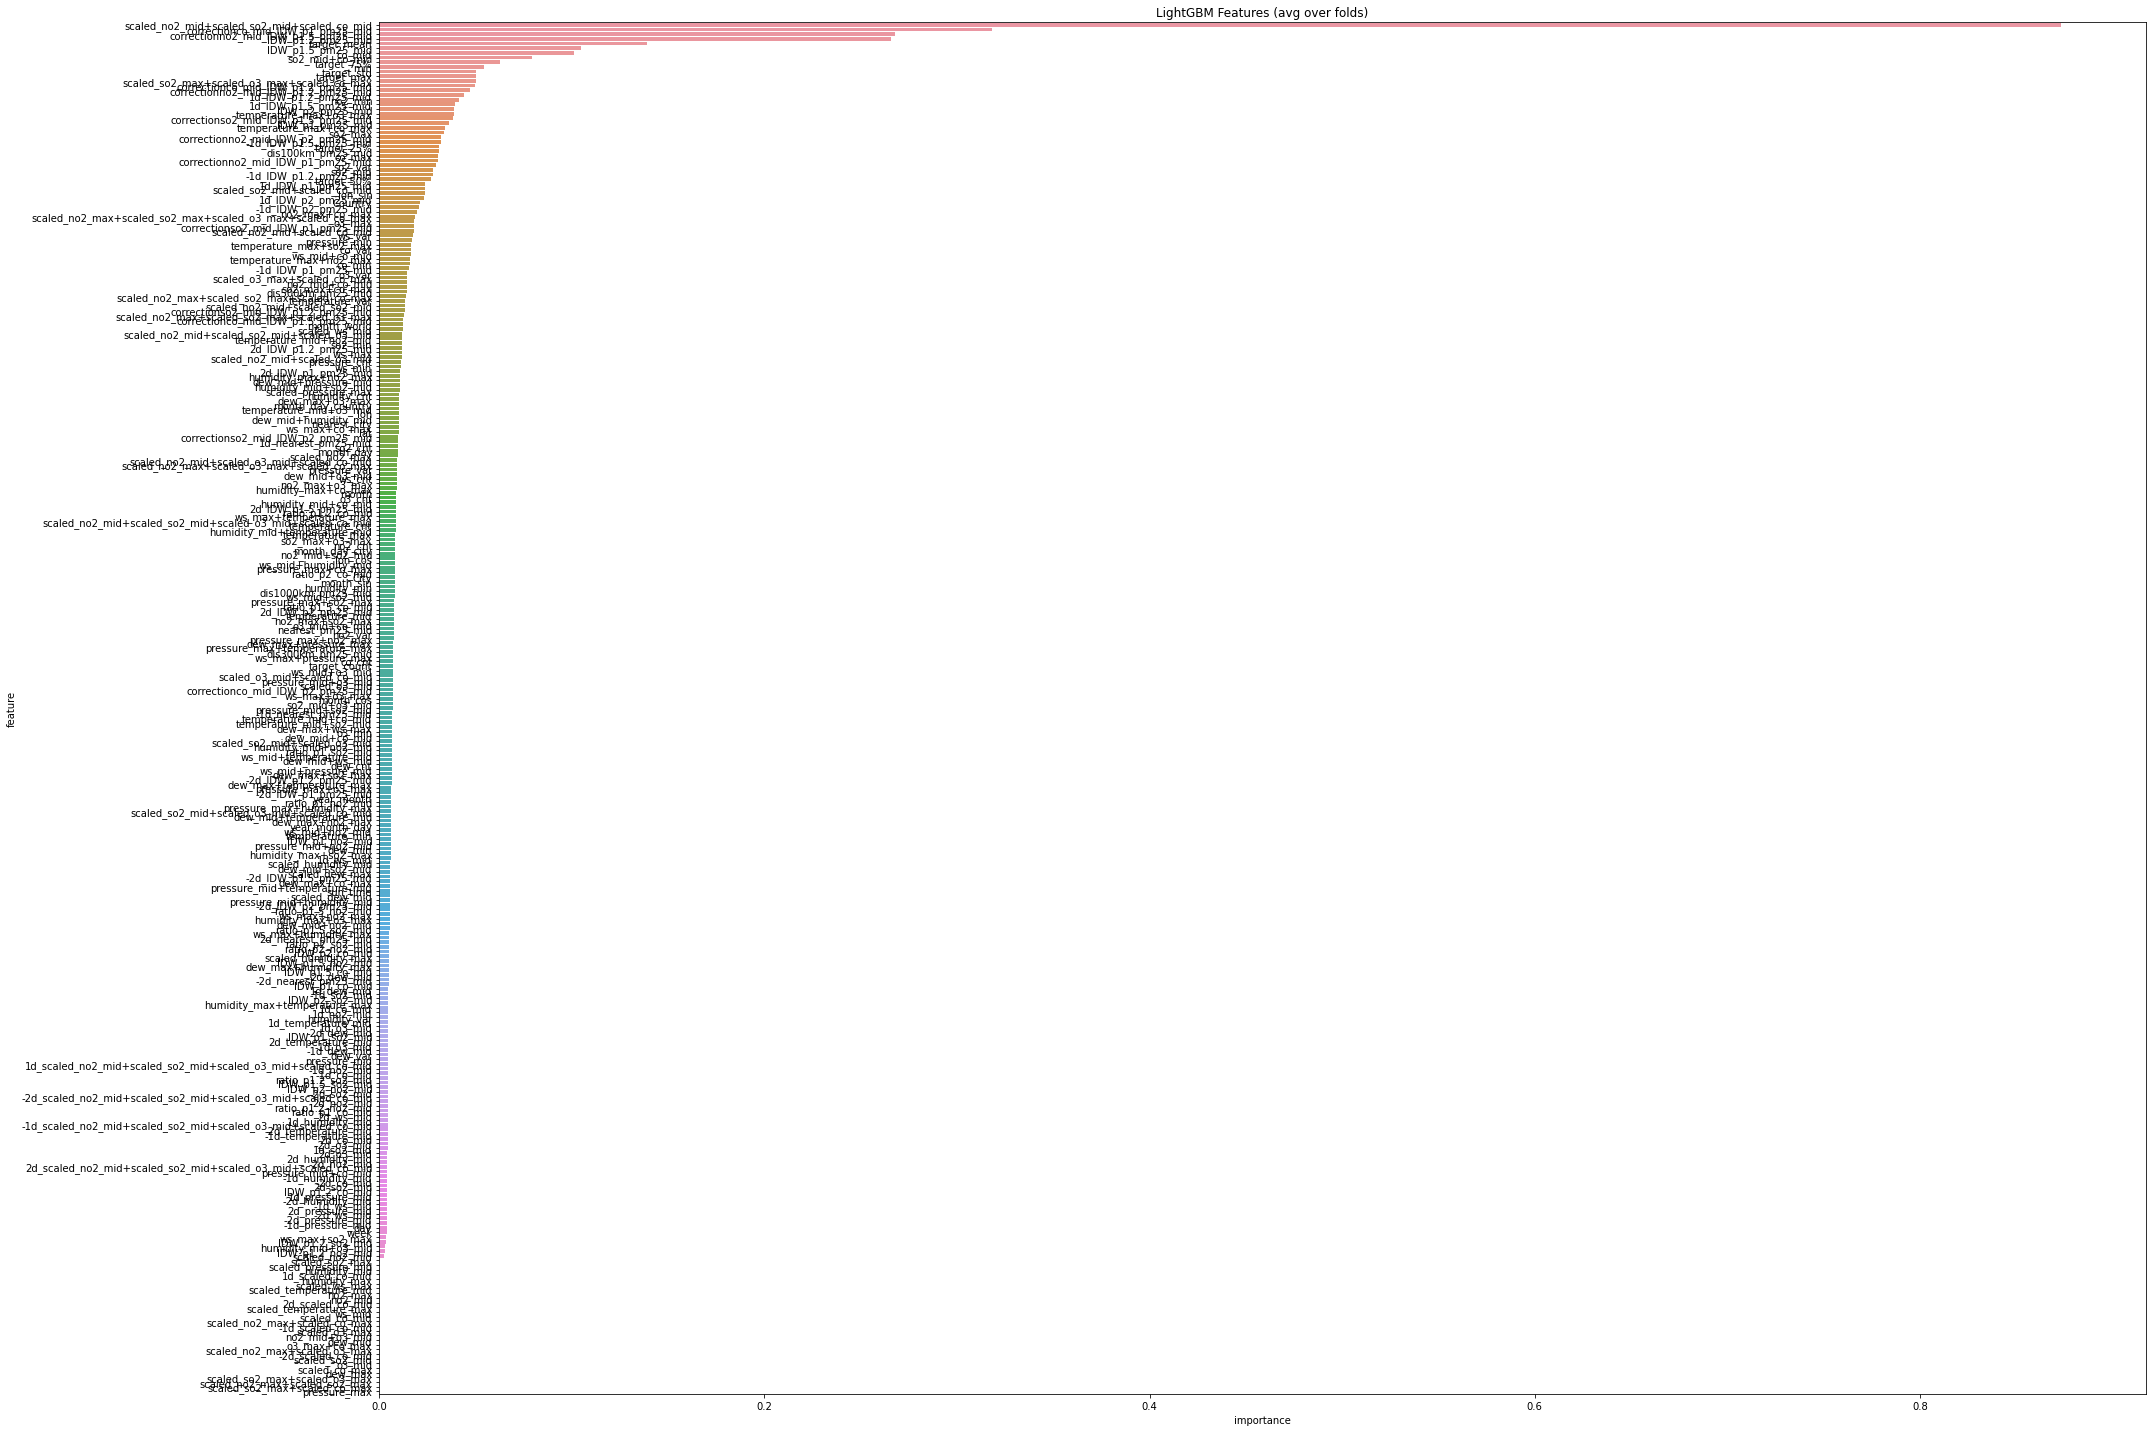

In [ ]:
viz_feature_importances(feature_importance)

In [ ]:
feature_importance.groupby("feature").agg({
    "importance": ["mean", "std"]
}).sort_values(("importance", "mean"), ascending=0).head(50)

importance    
                                                         mean std
feature                                                          
scaled_no2_mid+scaled_so2_mid+scaled_co_mid          0.873564 NaN
correctionco_mid_IDW_p1_pm25_mid                     0.318403 NaN
correctionno2_mid_IDW_p1.5_pm25_mid                  0.268032 NaN
IDW_p1.2_pm25_mid                                    0.265800 NaN
target_mean                                          0.139252 NaN
IDW_p1.5_pm25_mid                                    0.104788 NaN
co_mid                                               0.101064 NaN
so2_mid+co_mid                                       0.079334 NaN
target_75%                                           0.062619 NaN
min                                                  0.054303 NaN
target_std                                           0.050232 NaN
target_max                                           0.050174 NaN
scaled_so2_max+scaled_o3_max+scaled_co_max           0.049955 NaN
correctionco_mid_IDW_p1.2_pm25_mid                   0.049844 NaN
correctionno2_mid_IDW_p1.2_pm25_mid                  0.046865 NaN
1d_IDW_p1.2_pm25_mid                                 0.043800 NaN
no2_min                                              0.041182 NaN
1d_IDW_p1.5_pm25_mid                                 0.039210 NaN
IDW_p2_pm25_mid                                      0.039011 NaN
temperature_max+o3_max                               0.038710 NaN
correctionso2_mid_IDW_p1.5_pm25_mid                  0.038334 NaN
IDW_p1_pm25_mid                                      0.036234 NaN
temperature_max+co_max                               0.033870 NaN
so2_max                                              0.033642 NaN
correctionno2_mid_IDW_p2_pm25_mid                    0.031794 NaN
-1d_IDW_p1.5_pm25_mid                                0.031786 NaN
target_25%                                           0.030834 NaN
dis100km_pm25_mid                                    0.030770 NaN
co_max                                               0.030437 NaN
correctionno2_mid_IDW_p1_pm25_mid                    0.030399 NaN
so2_var                                              0.029600 NaN
so2_mid                                              0.027976 NaN
-1d_IDW_p1.2_pm25_mid                                0.027638 NaN
target_50%                                           0.026867 NaN
1d_IDW_p1_pm25_mid                                   0.023587 NaN
scaled_so2_mid+scaled_co_mid                         0.023560 NaN
lon_sin                                              0.023509 NaN
1d_IDW_p2_pm25_mid                                   0.022999 NaN
Country                                              0.021256 NaN
-1d_IDW_p2_pm25_mid                                  0.020434 NaN
no2_max+co_max                                       0.019432 NaN
scaled_no2_max+scaled_so2_max+scaled_o3_max+sca...   0.018628 NaN
o3_max                                               0.018164 NaN
correctionso2_mid_IDW_p1_pm25_mid                    0.017991 NaN
scaled_no2_mid+scaled_co_mid                         0.017770 NaN
ws_var                                               0.017449 NaN
pressure_min                                         0.016886 NaN
temperature_max+so2_max                              0.016626 NaN
co_var                                               0.016466 NaN
ws_mid+co_mid                                        0.016272 NaN

In [ ]:
a = np.clip(train_oof["oof"], 0, 450)
oof_score = np.sqrt(mean_squared_error(train_oof["pm25_mid"], a))
oof_score = format(oof_score, ".4f")
print(f"oof score: {oof_score}")

### d_cs_flg 21.89 ###

oof score: 21.4485


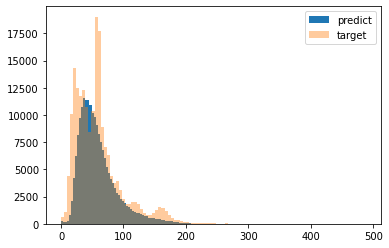

In [ ]:
plt.hist(a, bins = 100, label = "predict")
plt.hist(train_oof["pm25_mid"], bins = 100, label = "target", alpha = 0.4)
plt.legend()
plt.show()

In [ ]:
train_oof[["id","pm25_mid", "kfold", "oof"]].to_csv(os.path.join(OOF_DIR, "oof.csv"), index= False)

In [ ]:
models = []
for i in range(NUM_FOLDS):
    with open(os.path.join(SAVE_DIR, f"model_{i}.pkl"), "rb") as p:
        model = pickle.load(p)
    models.append(model)

[18:00:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:00:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:00:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:00:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:00:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


# predict

In [ ]:
sum_predict = None
for model in models:
    predict = model.predict(
        test_df__[use_cols],
    )
    if sum_predict is None:
        sum_predict = predict
    else:
        sum_predict += predict

mean_predict = sum_predict / len(models)

In [ ]:
print(len(mean_predict))
print(sample_df.shape)
print(test_df.shape)

53509
(53509, 2)
(53509, 79)


In [ ]:
sample_df.loc[:,"predict"] = np.clip(mean_predict, 0, 450)

In [ ]:
sample_df.head()

,id,predict
0,195942,25.735912
1,195943,40.749382
2,195944,29.307316
3,195945,74.730148
4,195946,130.075058


In [ ]:
sample_df.to_csv(os.path.join(SUB_DIR, "submission.csv"), index= False, header = False)

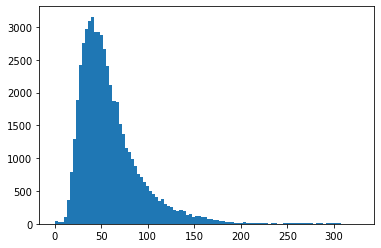

In [ ]:
plt.hist(sample_df["predict"], bins = 100)
plt.show()

# submit

In [ ]:
!pip install signate > /dev/null
!mkdir /root/.signate
!cp /content/drive/MyDrive/signate/signate.json /root/.signate/signate.json

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0+zzzcolab20220506162203 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.9 which is incompatible.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
submission_file = os.path.join(SUB_DIR, "submission.csv")

In [ ]:
comment = f"cv:{oof_score}_" + NOTEBOOK_NAME
comment

'cv:21.4485_FP060-059'

# Submit

In [ ]:
!signate submit --competition-id=624 {submission_file} --note {comment}

You have successfully submitted your predictions.We will send you the submission result to your email address.


https://signate.jp/competitions/624/submissions

In [ ]:
train_df[["City", "month", "pm25_mid"]].groupby(["City"]).describe()

In [ ]:
test_df__[["IDW_p1_pm25_mid", "IDW_p2_pm25_mid"]]

In [ ]:
train_df[["co_cnt", "co_var", "co_min", "co_max", "co_mid"]]

In [ ]:
gen = np.random.default_rng()

rnd = gen.normal(size=38)

print(len(rnd), rnd.mean(), rnd.std())

In [ ]:
plt.hist(train_df[train_df["City"] == "Adapazarı"]["pm25_mid"], bins = 100)